In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import plotly.express as px
import numpy as np
import math
import pandas as pd
from shapely.geometry import Polygon, LineString, Point, MultiPolygon
import rdflib
from rdflib import Namespace, URIRef, BNode
from rdflib.namespace import RDF, FOAF, OWL, RDFS, XSD
from time import time #importamos la función time para capturar tiempos
import ontospy
from ontospy import *
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
#import kglab
import os
import igraph as ig
import leidenalg as la
import community as community_louvain
import networkx.algorithms.community as nx_comm
import geopandas as gpd
import json
from sklearn.cluster import DBSCAN 

In [2]:
carpetas=pd.read_csv('homicidioscdmx.csv')
agebinfo=pd.read_csv('agebspob.csv')

In [3]:
carpetas['colonia_datos'].replace(np.NaN,'No especificado',inplace=True)
carpetas['Sexo'].replace(np.NaN,'No especificado',inplace=True)
carpetas['Edad'].replace(np.NaN,'No especificado',inplace=True)


In [4]:
carpetas=carpetas[(carpetas['Año_hecho']>=2017) & (carpetas['Año_hecho']<=2022)]
carpetas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4021 entries, 0 to 4020
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0.1          4021 non-null   int64  
 1   index                 4021 non-null   int64  
 2   Unnamed: 0            4021 non-null   int64  
 3   idCarpeta             4021 non-null   float64
 4   Año_inicio            4021 non-null   int64  
 5   Mes_inicio            4021 non-null   object 
 6   FechaInicio           4021 non-null   object 
 7   Delito                4021 non-null   object 
 8   Categoria             4021 non-null   object 
 9   Sexo                  4021 non-null   object 
 10  Edad                  4021 non-null   object 
 11  TipoPersona           4017 non-null   object 
 12  CalidadJuridica       4021 non-null   object 
 13  competencia           4021 non-null   object 
 14  Año_hecho             4021 non-null   float64
 15  Mes_hecho            

In [5]:
carpetas['longitudrad'] = np.radians(carpetas.longitud)
carpetas['latitudrad'] = np.radians(carpetas.latitud)
carpetas.Edad.replace('No especificado','0.0',inplace=True)
carpetas.Edad = carpetas.Edad.astype(float)
carpetas.Edad = carpetas.Edad.astype(int)
edades = [0, 18, 64, float('inf')]
# Etiquetas para los grupos etarios
etiquetas_edad = ['0-18', '19-64', '65+']
mapeo2 = {'0-18': 1, '19-64': 2, '65+': 3}


carpetas['grupo_etario'] = pd.cut(carpetas['Edad'], bins=edades, labels=etiquetas_edad, right=False)
carpetas['grupo_etario2'] = carpetas['grupo_etario'].map(mapeo2)
carpetas['genero2'] = carpetas['Sexo'].replace({'Masculino':1,'Femenino':2,'No especificado':3})
carpetas['año'] = carpetas['Año_hecho']


In [6]:
carpetas

Unnamed: 0.1   index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0                0     188         192  8325049.0        2019      Enero   
1                1     384         389  8325655.0        2019      Enero   
2                2     454         460  8325855.0        2019      Enero   
3                3     512         520  8326053.0        2019      Enero   
4                4     519         527  8326074.0        2019      Enero   
...            ...     ...         ...        ...         ...        ...   
4016          4140  965826      973633  9361524.0        2022  Diciembre   
4017          4141  968068      978150  9366167.0        2023      Enero   
4018          4142  968069      978151  9366167.0        2023      Enero   
4019          4143  968070      978152  9366167.0        2023      Enero   
4020          4144  971509      994838  9383799.0        2023    Febrero   

     FechaInicio                       Delito         Categoria       Sexo  \
0     2019-01-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
1     2019-01-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2     2019-01-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3     2019-01-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4     2019-01-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
...          ...                          ...               ...        ...   
4016  2022-12-30  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4017  2023-01-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4018  2023-01-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4019  2023-01-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
4020  2023-02-01  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

      ...    latitud   longitud  ageb shp  longitudrad latitudrad  \
0     ...  19.237800 -99.144230  0813 NaN    -1.730393   0.335763   
1     ...  19.395180 -99.193390  1773 NaN    -1.731251   0.338510   
2     ...  19.366760 -99.087920  0750 NaN    -1.729410   0.338014   
3     ...  19.272320 -99.135920  0067 NaN    -1.730248   0.336365   
4     ...  19.309127 -99.206300  1307 NaN    -1.731477   0.337008   
...   ...        ...        ...   ...  ..          ...        ...   
4016  ...  19.441201 -99.119868  0371 NaN    -1.729968   0.339313   
4017  ...  19.361090 -99.031424  1091 NaN    -1.728424   0.337915   
4018  ...  19.361090 -99.031424  1091 NaN    -1.728424   0.337915   
4019  ...  19.361090 -99.031424  1091 NaN    -1.728424   0.337915   
4020  ...  19.439233 -99.080478  0352 NaN    -1.729281   0.339279   

     grupo_etario grupo_etario2 genero2     año  
0           19-64             2       1  2019.0  
1           19-64             2       1  2019.0  
2           19-64             2       1  2019.0  
3           19-64             2       1  2019.0  
4           19-64             2       1  2019.0  
...           ...           ...     ...     ...  
4016         0-18             1       1  2022.0  
4017        19-64             2       1  2022.0  
4018         0-18             1       1  2022.0  
4019        19-64             2       2  2022.0  
4020        19-64             2       1  2022.0  

[4021 rows x 33 columns]

In [7]:
alcal=gpd.read_file('ageb_pobreza.shp')
alcal=alcal.to_crs('EPSG:4326')

ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Axes: >

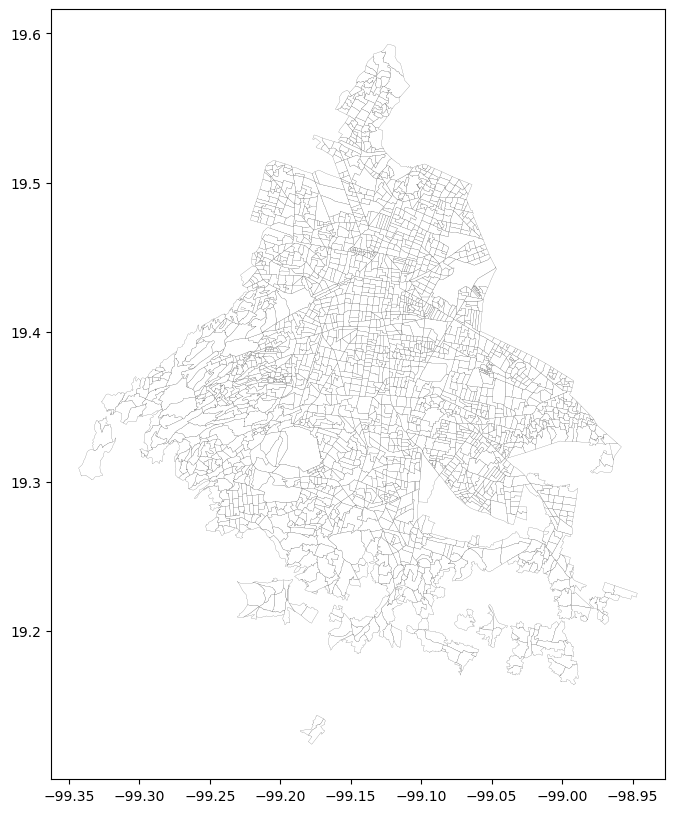

In [8]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.1)


In [9]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Average Cluster Coefficients:", nx.average_clustering(graph))
    print("Connected components:", len(list(nx.connected_components(graph))))

In [10]:
 
def convert_communities_dict_to_list(communities_dict):
    unique_partition_count = len(list(set(communities_dict.values())))
    print("Number of unique communities:", unique_partition_count)
    communities = [[] for i in range(unique_partition_count)]
    for node in communities_dict.keys():
        communities[communities_dict[node]].append(node)
    return communities

In [11]:
# function to check whether the determined communities are connected
def check_community_disconnection(graph, communities):
    total_connected = 0
    disconnected_community_indexes = []
    for i in range(len(communities)):
        if nx.is_connected(graph.subgraph(communities[i])):
            total_connected += 1
        else:
            disconnected_community_indexes.append(i)
    print("Total Communities:", len(communities))
    print("Total Communities Connected:", total_connected)
    print("Disconnected Community Indexes:", disconnected_community_indexes)

In [12]:
# Carga el grafo desde el archivo JSON
with open("grafoarmfuego4.json", "r") as json_file:
    graph_data = json.load(json_file)

# Crea un grafo de NetworkX a partir de los datos cargados
G = nx.readwrite.json_graph.node_link_graph(graph_data)


In [13]:
'http://localhost/HOMICIDIO_POR_ARMA_DE_FUEGO' in list(G.nodes())

True

In [14]:
# Número de nodos y enlaces
num_nodos = G.number_of_nodes()
num_enlaces = G.number_of_edges()

print("Número de nodos:", num_nodos)
print("Número de enlaces:", num_enlaces)



Número de nodos: 12938
Número de enlaces: 46557


In [15]:
import networkx as nx

# Supongamos que G es tu grafo
nodos_homicidio = [nodo for nodo in G.nodes if 'HOMICIDIO' in nodo]
print(len(nodos_homicidio))


2


In [16]:
#vecin = list(G.neighbors('http://localhost/0'))
vecin2 = list(G.neighbors( 'http://localhost/AGEB0813'))
vecin2[0]

'http://localhost/ontology2#Lugar'

In [17]:
vecino=[]
#for i in range(0,len(vecin)):
 #   vecino.append(vecin[i])

for i in range(0,len(vecin2)):
    vecino.append(vecin2[i])

subg=G.subgraph(vecino)


In [18]:
vecino

['http://localhost/ontology2#Lugar',
 '[ 50, 70]',
 'http://localhost/ontology2#AGEB',
 '0',
 '4180',
 '12615',
 '1848',
 "(array('d', [-99.1439938497202]), array('d', [19.2394036202517]))",
 'http://localhost/8652886',
 'http://localhost/9074988',
 '65',
 'http://localhost/8325049',
 "(array('d', [-99.1440414197777]), array('d', [19.2425142290385]))",
 'http://localhost/9223798',
 "(array('d', [-99.1438013876185]), array('d', [19.2351378783241]))",
 "(array('d', [-99.14423]), array('d', [19.2378]))"]

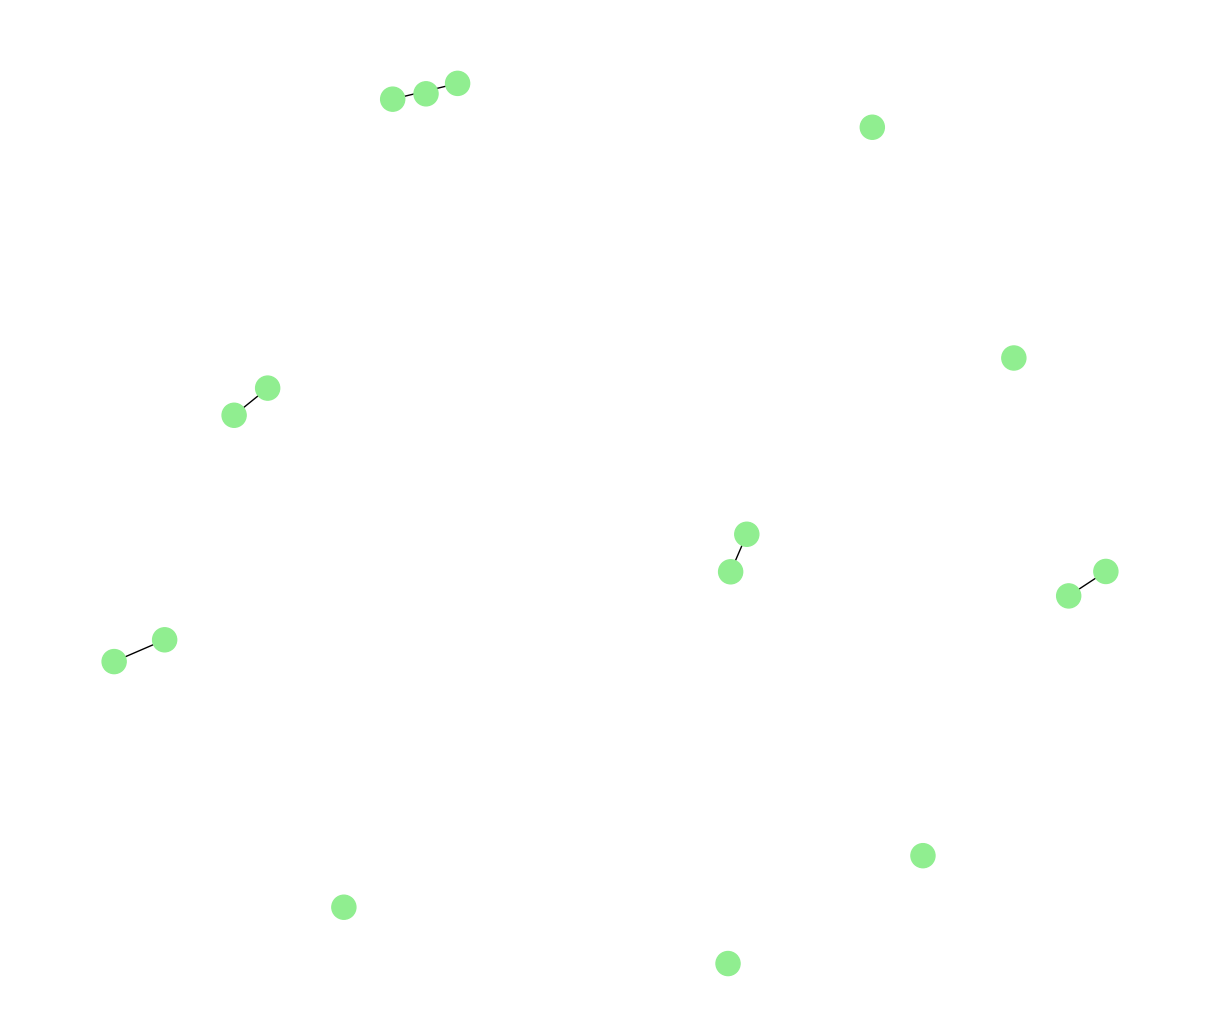

In [19]:
# Plotear el subgrafo
import matplotlib.pyplot as plt

# Definir el tamaño de los nodos y los labels
node_size = 300  # Tamaño de los nodos
font_size = 8  # Tamaño de los labels

colors = []
for nodo in subg.nodes():
    if nodo == 'http://localhost/0':
        colors.append('red')  # Color rojo para el nodo 'Masculino'
    elif nodo == 'http://localhost/HOMICIDIO_POR_ARMA_DE_FUEGO':
        colors.append('blue')  # Color azul para este nodo
    elif nodo == 'http://localhost/AGEB0813':
        colors.append('green')  # Color azul para este nodo
    else:
        colors.append('lightgreen')  # Color verde claro para los demás nodos

# Dibujar el subgrafo con los parámetros ajustados
plt.figure(figsize=(12, 10))  # Opcional: ajustar el tamaño de la figura
nx.draw(subg, with_labels=False, node_size=node_size, font_size=font_size, node_color=colors, font_weight='bold')
plt.savefig('Fig1Louvain.jpg',format='JPEG')
plt.show()


In [20]:
louvain_communitiesrdf = community_louvain.best_partition(G, random_state=123)

In [21]:
louvain_communities2rdf = convert_communities_dict_to_list(louvain_communitiesrdf)
louvain_communities2rdf

Number of unique communities: 73


[['http://localhost/8671489',
  'http://localhost/8620888',
  '2020-01-28',
  'http://localhost/AGEB0984',
  '214715',
  'http://localhost/8561850',
  'http://localhost/9204238',
  'http://localhost/8734405',
  'http://localhost/9340319',
  'http://localhost/8823936',
  'http://localhost/AGEB1523',
  'http://localhost/9340422',
  'http://localhost/AGEB5677',
  'http://localhost/8562027',
  '5471',
  'http://localhost/AGEB0584',
  'http://localhost/AGEB1042',
  '5802',
  'http://localhost/8422890',
  "(array('d', [-99.2303]), array('d', [19.34924]))",
  'http://localhost/8982044',
  'http://localhost/AGEB1427',
  'http://localhost/8561674',
  'http://localhost/8805624',
  "(array('d', [-99.2118837404413]), array('d', [19.3801153466799]))",
  "(array('d', [-99.2696696496166]), array('d', [19.3039752295023]))",
  '16639',
  "(array('d', [-99.03024]), array('d', [19.33829]))",
  'http://localhost/AGEB1078',
  'http://localhost/AGEB2574',
  "(array('d', [-99.13635]), array('d', [19.53127]))

In [22]:
%%time

# take a look at the modularity of the Louvain algorithm output
print("Modularity:", 
      round(nx_comm.modularity(G, louvain_communities2rdf), 6))

Modularity: 0.400476
CPU times: total: 46.9 ms
Wall time: 52.1 ms


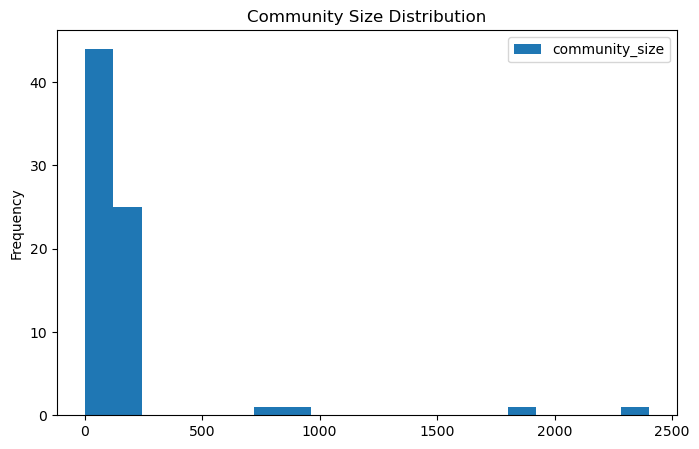

In [23]:
community_sizes = pd.DataFrame([len(community) for community in louvain_communities2rdf], 
                               columns=["community_size"])
community_sizes.plot.hist(bins=20, figsize=(8,5), title="Community Size Distribution");

In [24]:
def get_communities_lists(community_dict):
    communities_lists = {}  # Un diccionario donde las claves son los números de comunidad y los valores son las listas de nodos
    for node, community in community_dict.items():
        if community not in communities_lists:
            communities_lists[community] = []
        communities_lists[community].append(node)
    return communities_lists

# Ejemplo de cómo usar la función para obtener todas las comunidades en diferentes listas
all_communities_lists = get_communities_lists(louvain_communitiesrdf)



In [25]:
len(all_communities_lists[0])

123

In [26]:
# Crear un diccionario para almacenar los subgrafos y sus medidas de centralidad
subgrafos_y_centralidad = {}

# Iterar a través de cada comunidad y crear un subgrafo en NetworkX
for comunidad, nodos in all_communities_lists.items():
    subgrafo_nx = G.subgraph(nodos)  # G es tu grafo original de NetworkX
    
    # Convertir el subgrafo de NetworkX a igraph
    subgrafo_ig = ig.Graph(directed=False)
    
    # Agregar nodos con índices únicos para igraph
    node_mapping = {}  # Diccionario para mapear nodos originales a índices en igraph
    for nodo in subgrafo_nx.nodes():
        idx = subgrafo_ig.add_vertex()  # Agregar un nodo en igraph y obtener su índice
        node_mapping[nodo] = idx  # Asociar el nodo original con el índice en igraph
    
    # Agregar aristas con índices únicos
    for edge in subgrafo_nx.edges():
        source = node_mapping[edge[0]]
        target = node_mapping[edge[1]]
        subgrafo_ig.add_edge(source, target)
        
    # Crear el mapeo inverso de índices a URIs
    index_to_uri_mapping = {index: uri for uri, index in node_mapping.items()}
    
    
    closeness=subgrafo_ig.closeness()
    average_closeness = sum(closeness) / subgrafo_ig.vcount()
    centralidad = subgrafo_ig.betweenness()  # Calcular la centralidad que desees
    most_central_node1 = centralidad.index(max(centralidad))
    centralidad = sum(centralidad) / subgrafo_ig.vcount()
    
    for vertex, uri in index_to_uri_mapping.items():
        index_number = int(str(vertex).split()[-2].replace(',',''))
        if index_number==most_central_node1:
            nodouri=uri
    subgrafos_y_centralidad[comunidad] = {
        'subgrafo': subgrafo_ig,
        'centralidad': centralidad,
        'closeness' : average_closeness,
        'nodo central': most_central_node1,
        'uri': nodouri,
        'mapeo':index_to_uri_mapping
    }

# Ahora puedes acceder a los subgrafos y medidas de centralidad por comunidad
for comunidad, data in subgrafos_y_centralidad.items():
    print(f"Comunidad: {comunidad}")
    print("Centralidad:", data['centralidad'])
    print('closeness: ',data['closeness'])
    print("Número de nodos en el subgrafo:", data['subgrafo'].vcount())
    print("Número de enlaces en el subgrafo:", data['subgrafo'].ecount())
    print('Shortest path', data['subgrafo'].average_path_length())
    print('central node',data['nodo central'])
    print('nodo uri',data['uri'])
    print("-----")

Comunidad: 0
Centralidad: 560.3658536585366
closeness:  0.10291888061155641
Número de nodos en el subgrafo: 123
Número de enlaces en el subgrafo: 141
Shortest path 10.186325469812076
central node 14
nodo uri 118
-----
Comunidad: 1
Centralidad: 1702.484110169494
closeness:  0.367931754589888
Número de nodos en el subgrafo: 1888
Número de enlaces en el subgrafo: 8590
Shortest path 2.8044346689660746
central node 809
nodo uri http://localhost/ontology2#obs
-----
Comunidad: 9
Centralidad: 537.9532710280373
closeness:  0.16981090595898635
Número de nodos en el subgrafo: 214
Número de enlaces en el subgrafo: 256
Shortest path 6.051204422798473
central node 98
nodo uri 55
-----
Comunidad: 3
Centralidad: 364.6185567010309
closeness:  0.12052834002524171
Número de nodos en el subgrafo: 97
Número de enlaces en el subgrafo: 110
Shortest path 8.596219931271477
central node 52
nodo uri 56
-----
Comunidad: 4
Centralidad: 486.4825174825174
closeness:  0.1303426137806917
Número de nodos en el subgrafo

In [27]:
'http://localhost/HOMICIDIO_POR_ARMA_BLANCA' in all_communities_lists[2]

False

In [28]:
centralidades=[]
for comunidad, data in subgrafos_y_centralidad.items():
    com= comunidad
    centr= data['centralidad']
    centralidades.append([com,centr])



## subgrafos_y_centralidad[0]

In [29]:
sorted(centralidades)

[[0, 560.3658536585366],
 [1, 1702.484110169494],
 [2, 0.0],
 [3, 364.6185567010309],
 [4, 486.4825174825174],
 [5, 1083.793672627235],
 [6, 602.4915611814389],
 [7, 298.45255474452557],
 [8, 442.5357142857143],
 [9, 537.9532710280373],
 [10, 540.1496062992126],
 [11, 260.3191489361702],
 [12, 3202.2940441482733],
 [13, 676.0829875518673],
 [14, 392.4154929577465],
 [15, 181.56410256410257],
 [16, 255.04166666666666],
 [17, 274.968085106383],
 [18, 564.2364864864865],
 [19, 377.8859649122807],
 [20, 493.1],
 [21, 433.2887323943661],
 [22, 493.36486486486484],
 [23, 263.3882352941176],
 [24, 174.21276595744683],
 [25, 297.0081967213115],
 [26, 511.08227848101274],
 [27, 441.469696969697],
 [28, 319.2115384615385],
 [29, 242.49367088607596],
 [30, 632.1081081081081],
 [31, 226.43037974683546],
 [32, 568.6923076923077],
 [33, 540.8488372093024],
 [34, 407.34736842105264],
 [35, 232.28571428571425],
 [36, 42.115384615384606],
 [37, 206.2027027027027],
 [38, 256.92857142857144],
 [39, 680.9

In [30]:
all_communities_lists[1]

['http://localhost/HOMICIDIO_POR_ARMA_DE_FUEGO',
 'http://localhost/8790171',
 'http://localhost/TLALPAN',
 'http://localhost/8419671',
 'Masculino',
 'http://localhost/9098648',
 'Femenino',
 'http://localhost/8858636',
 'http://localhost/8454529',
 'http://localhost/ontology2#obs',
 'http://localhost/8933458',
 '21.0',
 'http://localhost/8553594',
 'http://localhost/8999578',
 'http://localhost/8521818',
 'http://localhost/8430914',
 'http://localhost/9258858',
 'http://localhost/9284563',
 '23.0',
 'http://localhost/8861181',
 'http://localhost/HOMICIDIO_DOLOSO',
 'http://localhost/8612469',
 'http://localhost/8590890',
 'http://localhost/8994093',
 '2021-08-13',
 'http://localhost/8399323',
 'http://localhost/8483350',
 'http://localhost/8629421',
 'http://localhost/8897650',
 'http://localhost/CONSEJO_AGRARISTA_MEXICANO_I_IZTAPALAPA',
 'http://localhost/8692882',
 'http://localhost/9039987',
 'http://localhost/VENUSTIANO_CARRANZA',
 'http://localhost/8322550',
 'http://localhost/8

In [31]:
import re

patron = re.compile(r'^http://localhost/(\d+)$')
ids={}
n_num=[]
for community, ele in all_communities_lists.items():
    #print(ele)# Filtrar los nodos que cumplen con esa condición
    nodos_numericos = [n for n in ele if isinstance(n, str) and patron.match(n)]
    n_num.extend(nodos_numericos)
    print(nodos_numericos)
    #Extraer el número, convertirlo a float
    resultados = [float(url.split('/')[-1]) for url in nodos_numericos]
    ids[community]=resultados

#print(nodos_numericos)

['http://localhost/8671489', 'http://localhost/8620888', 'http://localhost/8561850', 'http://localhost/9204238', 'http://localhost/8734405', 'http://localhost/9340319', 'http://localhost/8823936', 'http://localhost/9340422', 'http://localhost/8562027', 'http://localhost/8422890', 'http://localhost/8982044', 'http://localhost/8561674', 'http://localhost/8805624', 'http://localhost/8839880', 'http://localhost/8879140', 'http://localhost/8422482', 'http://localhost/9052071', 'http://localhost/9035069', 'http://localhost/8734070', 'http://localhost/9340341']
['http://localhost/8790171', 'http://localhost/8419671', 'http://localhost/9098648', 'http://localhost/8858636', 'http://localhost/8454529', 'http://localhost/8933458', 'http://localhost/8553594', 'http://localhost/8999578', 'http://localhost/8521818', 'http://localhost/8430914', 'http://localhost/9258858', 'http://localhost/9284563', 'http://localhost/8861181', 'http://localhost/8612469', 'http://localhost/8590890', 'http://localhost/

In [32]:
def getdatafromids(data, dictids):
    dataids = {}
    for community, elements in dictids.items():
        dataids[community] = pd.DataFrame()  # Crear un DataFrame vacío para cada comunidad
        for ele in elements:
            ele=float(ele)
            
            row = data[data['idCarpeta']==ele]
            print(row)
            dataids[community] = pd.concat([dataids[community],row])
    return dataids

# Crea un diccionario vacío para almacenar los DataFrames por comunidad

In [33]:
dfcomun=getdatafromids(carpetas,ids)

      Unnamed: 0.1   index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
1668          1703  328256      331616  8671489.0        2020      Abril   

     FechaInicio                       Delito         Categoria       Sexo  \
1668  2020-04-02  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

      ...    latitud   longitud  ageb shp  longitudrad latitudrad  \
1668  ...  19.474505 -99.208133  1042 NaN    -1.731509   0.339894   

     grupo_etario grupo_etario2 genero2     año  
1668        19-64             2       1  2020.0  

[1 rows x 33 columns]
      Unnamed: 0.1   index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
1439          1468  280868      283798  8620888.0        2020      Enero   

     FechaInicio                       Delito         Categoria       Sexo  \
1439  2020-01-28  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

      ...    latitud   longitud  ageb shp  longitudrad latitudrad  \
1439  ...  19.347864 -99.231858  1078 NaN    -1.7

In [34]:
dfcomun[0]

Unnamed: 0.1   index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
1668          1703  328256      331616  8671489.0        2020      Abril   
1439          1468  280868      283798  8620888.0        2020      Enero   
767            787  143591      145111  8561850.0        2019  Noviembre   
3592          3695  816801      823665  9204238.0        2022       Mayo   
2092          2142  387315      391011  8734405.0        2020     Agosto   
3949          4071  945620      953315  9340319.0        2022  Noviembre   
2456          2516  471252      475610  8823936.0        2020  Diciembre   
3951          4073  945723      953418  9340422.0        2022  Noviembre   
768            788  143644      145164  8562027.0        2019  Noviembre   
1274          1299  248566      251150  8422890.0        2019       Mayo   
3001          3081  610363      615796  8982044.0        2021      Julio   
1202          1224  235192      237576  8561674.0        2019  Noviembre   
2382          2437  454038      458267  8805624.0        2020  Noviembre   
2523          2586  486349      490822  8839880.0        2021      Enero   
2691          2761  523256      527982  8879140.0        2021      Marzo   
622            636  121947      123225  8422482.0        2019       Mayo   
3218          3307  675739      681656  9052071.0        2021  Noviembre   
3178          3265  659822      665616  9035069.0        2021    Octubre   
2090          2140  386994      390688  8734070.0        2020     Agosto   
3950          4072  945642      953337  9340341.0        2022  Noviembre   

     FechaInicio                       Delito         Categoria       Sexo  \
1668  2020-04-02  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
1439  2020-01-28  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
767   2019-11-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3592  2022-05-31  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2092  2020-08-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3949  2022-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2456  2020-12-22  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3951  2022-11-30  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
768   2019-11-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
1274  2019-05-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3001  2021-07-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
1202  2019-11-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2382  2020-11-24  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2523  2021-01-21  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2691  2021-03-22  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
622   2019-05-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3218  2021-11-03  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3178  2021-10-10  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2090  2020-08-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3950  2022-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

      ...    latitud   longitud  ageb shp  longitudrad latitudrad  \
1668  ...  19.474505 -99.208133  1042 NaN    -1.731509   0.339894   
1439  ...  19.347864 -99.231858  1078 NaN    -1.731923   0.337684   
767   ...  19.338290 -99.030240  2901 NaN    -1.728404   0.337517   
3592  ...  19.380115 -99.211884  1523 NaN    -1.731574   0.338247   
2092  ...  19.301629 -99.078338  3505 NaN    -1.729243   0.336877   
3949  ...  19.268425 -99.007475  1427 NaN    -1.728006   0.336297   
2456  ...  19.377293 -99.122394  0322 NaN    -1.730012   0.338198   
3951  ...  19.366218 -99.033909  5677 NaN    -1.728468   0.338004   
768   ...  19.308780 -99.169850  1622 NaN    -1.730840   0.337002   
1274  ...  19.349240 -99.230300  1078 NaN    -1.731895   0.337708   
3001  ...  

In [35]:
import pandas as pd

# Supongamos que df_comun es tu diccionario de DataFrames
# Cada DataFrame debe tener columnas 'latitud' y 'longitud'

# Lista para guardar los dataframes modificados
dataframes = []

for comunidad, df in dfcomun.items():
    df_copy = df.copy()
    df_copy["comunidad"] = comunidad  # Añade columna con el nombre de la comunidad
    dataframes.append(df_copy)

# Concatenar todos los DataFrames en uno solo
df_todo = pd.concat(dataframes, ignore_index=True)

# Verifica el resultado
print(df_todo.head())

   Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0        1703.0  328256.0    331616.0  8671489.0      2020.0      Abril   
1        1468.0  280868.0    283798.0  8620888.0      2020.0      Enero   
2         787.0  143591.0    145111.0  8561850.0      2019.0  Noviembre   
3        3695.0  816801.0    823665.0  9204238.0      2022.0       Mayo   
4        2142.0  387315.0    391011.0  8734405.0      2020.0     Agosto   

  FechaInicio                       Delito         Categoria       Sexo  ...  \
0  2020-04-02  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
1  2020-01-28  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
2  2019-11-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
3  2022-05-31  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
4  2020-08-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   

    longitud  ageb shp longitudrad  latitudrad grupo_etario grupo_et

In [36]:
from shapely.geometry import Point

# Crear la columna de geometría
df_todo["geometry"] = df_todo.apply(lambda row: Point(row["longitud"], row["latitud"]), axis=1)


In [37]:
df_todo=df_todo[df_todo['longitud']<-20]

In [38]:
import geopandas as gpd

gdf_todo = gpd.GeoDataFrame(df_todo, geometry="geometry", crs="EPSG:4326")


In [39]:
gdf_todo

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0           1703.0  328256.0    331616.0  8671489.0      2020.0      Abril   
1           1468.0  280868.0    283798.0  8620888.0      2020.0      Enero   
2            787.0  143591.0    145111.0  8561850.0      2019.0  Noviembre   
3           3695.0  816801.0    823665.0  9204238.0      2022.0       Mayo   
4           2142.0  387315.0    391011.0  8734405.0      2020.0     Agosto   
...            ...       ...         ...        ...         ...        ...   
4016        1221.0  233225.0    235586.0  8506227.0      2019.0     Agosto   
4017        3665.0  807462.0    814249.0  9194285.0      2022.0       Mayo   
4018        3389.0  700403.0    706490.0  9078427.0      2021.0  Diciembre   
4019        3012.0  592077.0    597362.0  8962611.0      2021.0      Junio   
4020        2947.0  570605.0    575711.0  8939602.0      2021.0       Mayo   

     FechaInicio                       Delito         Categoria       Sexo  \
0     2020-04-02  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
1     2020-01-28  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2     2019-11-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3     2022-05-31  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4     2020-08-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
...          ...                          ...               ...        ...   
4016  2019-08-25  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
4017  2022-05-19  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4018  2021-12-09  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4019  2021-06-30  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4020  2021-05-30  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

      ...  ageb shp longitudrad latitudrad  grupo_etario grupo_etario2  \
0     ...  1042 NaN   -1.731509   0.339894         19-64             2   
1     ...  1078 NaN   -1.731923   0.337684         19-64             2   
2     ...  2901 NaN   -1.728404   0.337517          0-18             1   
3     ...  1523 NaN   -1.731574   0.338247         19-64             2   
4     ...  3505 NaN   -1.729243   0.336877         19-64             2   
...   ...   ...  ..         ...        ...           ...           ...   
4016  ...  0645 NaN   -1.729674   0.338405         19-64             2   
4017  ...  0645 NaN   -1.728736   0.336686         19-64             2   
4018  ...  3214 NaN   -1.730064   0.341198         19-64             2   
4019  ...  3214 NaN   -1.730065   0.341199         19-64             2   
4020  ...  0736 NaN   -1.730863   0.338079         19-64             2   

     genero2     año comunidad                    geometry  
0        1.0  2020.0         0  POINT (-99.20813 19.47451)  
1        1.0  2020.0         0  POINT (-99.23186 19.34786)  
2        1.0  2019.0         0  POINT (-99.03024 19.33829)  
3        1.0  2022.0         0  POINT (-99.21188 19.38012)  
4        1.0  2020.0         0  POINT (-99.07834 19.30163)  
...      ...     ...       ...                         ...  
4016     2.0  2019.0        70  POINT (-99.10303 19.38916)  
4017     1.0  2022.0        70  POINT (-99.04927 19.29069)  
4018     1.0  2021.0        71  POINT (-99.12535 19.54918)  
4019     1.0  2020.0        71  POINT (-99.12544 19.54927)  
4020     1.0  2021.0        72  POINT (-99.17112 19.37047)  

[3979 rows x 35 columns]

In [40]:
gdf2=gdf_todo[gdf_todo['alcaldia_hechos']=='IZTAPALAPA']
gdf2=gdf2.drop_duplicates(subset='idCarpeta')


In [41]:
gdf2.alcaldia_hechos.unique()

array(['IZTAPALAPA'], dtype=object)

In [42]:
alcal

CVEGEO   POBREZA POBREZAEX    ID  \
0     0900200010010  (18, 34]  [ 0, 20]     1   
1     0900200010025  [ 0, 18]  [ 0, 20]     2   
2     090020001003A  [ 0, 18]  [ 0, 20]     3   
3     0900200010044  [ 0, 18]  [ 0, 20]     4   
4     0900200010097  [ 0, 18]  [ 0, 20]     5   
...             ...       ...       ...   ...   
2427  0901700011488  (34, 50]  [ 0, 20]  2428   
2428  0901700011492  (34, 50]  [ 0, 20]  2429   
2429  0901700011505  [ 0, 18]  [ 0, 20]  2430   
2430  090170001151A  (18, 34]  [ 0, 20]  2431   
2431  0901700011524  (34, 50]  [ 0, 20]  2432   

                                               geometry  
0     POLYGON ((-99.20307 19.51415, -99.20319 19.513...  
1     POLYGON ((-99.19662 19.51270, -99.19662 19.511...  
2     POLYGON ((-99.20658 19.51169, -99.20611 19.511...  
3     POLYGON ((-99.20530 19.51033, -99.20529 19.510...  
4     POLYGON ((-99.20573 19.50454, -99.20630 19.504...  
...                                                 ...  
2427  POLYGON ((-99.05931 19.42789, -99.05934 19.427...  
2428  POLYGON ((-99.05931 19.42789, -99.05794 19.426...  
2429  POLYGON ((-99.06102 19.42776, -99.05995 19.426...  
2430  POLYGON ((-99.06253 19.42663, -99.06281 19.426...  
2431  POLYGON ((-99.05709 19.42377, -99.05723 19.422...  

[2432 rows x 5 columns]

In [43]:
# 1. Filtra la alcaldía Iztapalapa
iztapa = alcal[alcal['CVEGEO'].str.contains('09007')]

# 2. Asegúrate de que ambos GeoDataFrames tengan el mismo CRS
gdf2 = gdf2.to_crs(iztapa.crs)

# 3. Crear GeoDataFrame vacío con misma estructura que gdf2
gdff = gpd.GeoDataFrame(columns=gdf2.columns, crs=gdf2.crs)

# 4. Iterar por puntos de gdf2 y verificar si están contenidos en Iztapalapa
for i in range(len(gdf2)):
    row = gdf2.iloc[[i]]  # <- usa doble corchete para que sea un DataFrame
    point = row.geometry.values[0]
    
    # Verifica si está contenido en alguno de los polígonos de iztapa
    if iztapa.contains(point).any():
        gdff = pd.concat([gdff, row], ignore_index=True)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_30040\1499568121.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdff = pd.concat([gdff, row], ignore_index=True)
C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_30040\1499568121.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdff = pd.concat([gdff, row], ignore_index=True)
C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_30040\1499568121.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries i

In [73]:
valores_unicos = gdff['comunidad'].unique()
primeros_5 = valores_unicos[9:12]  # o [:8] para 8 valores
gdfg = gdff[gdff['comunidad'].isin(primeros_5)]


In [74]:
gdf2=gdff[gdff['comunidad']==15]
gdf2

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
277        2449.0  457453.0    461710.0  8809247.0      2020.0  Noviembre   
278        2610.0  490582.0    495085.0  8844387.0      2021.0      Enero   
279        4084.0  951057.0    958782.0  9345781.0      2022.0  Diciembre   
280        1982.0  361557.0    365105.0  8707114.0      2020.0      Junio   
281        2173.0  396077.0    399838.0  8743752.0      2020.0     Agosto   
282        1962.0  359712.0    363248.0  8705262.0      2020.0      Junio   
283         313.0   60417.0     61107.0  8414510.0      2019.0      Abril   
284        1964.0  359759.0    363295.0  8705206.0      2020.0      Junio   
285        4083.0  951021.0    958746.0  9345743.0      2022.0  Diciembre   
286        3325.0  681778.0    687746.0  9058570.0      2021.0  Noviembre   

    FechaInicio                       Delito         Categoria       Sexo  \
277  2020-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
278  2021-01-28  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
279  2022-12-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
280  2020-06-22  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
281  2020-08-23  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
282  2020-06-17  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
283  2019-04-28  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
284  2020-06-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
285  2022-12-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
286  2021-11-12  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  ageb shp longitudrad latitudrad  grupo_etario grupo_etario2 genero2  \
277  ...  1778 NaN   -1.729776   0.337509         19-64             2     1.0   
278  ...  1778 NaN   -1.729757   0.337494         19-64             2     1.0   
279  ...  1778 NaN   -1.729772   0.337520         19-64             2     1.0   
280  ...  1778 NaN   -1.729668   0.337509         19-64             2     1.0   
281  ...  2899 NaN   -1.728435   0.337510         19-64             2     1.0   
282  ...  1443 NaN   -1.728993   0.337729         19-64             2     1.0   
283  ...  1778 NaN   -1.729651   0.337505         19-64             2     1.0   
284  ...  1566 NaN   -1.729856   0.337619         19-64             2     1.0   
285  ...  2899 NaN   -1.728488   0.337500         19-64             2     1.0   
286  ...  2899 NaN   -1.728456   0.337459         19-64             2     1.0   

        año comunidad                    geometry  
277  2020.0        15  POINT (-99.10886 19.33784)  
278  2021.0        15  POINT (-99.10779 19.33700)  
279  2022.0        15  POINT (-99.10863 19.33848)  
280  2020.0        15  POINT (-99.10266 19.33785)  
281  2020.0        15  POINT (-99.03204 19.33790)  
282  2020.0        15  POINT (-99.06400 19.35043)  
283  2019.0        15  POINT (-99.10168 19.33763)  
284  2020.0        15  POINT (-99.11343 19.34417)  
285  2022.0        15  POINT (-99.03509 19.33733)  
286  2021.0        15  POINT (-99.03321 19.33499)  

[10 rows x 35 columns]

In [75]:
all_communities_lists

{0: ['http://localhost/8671489',
  'http://localhost/8620888',
  '2020-01-28',
  'http://localhost/AGEB0984',
  '214715',
  'http://localhost/8561850',
  'http://localhost/9204238',
  'http://localhost/8734405',
  'http://localhost/9340319',
  'http://localhost/8823936',
  'http://localhost/AGEB1523',
  'http://localhost/9340422',
  'http://localhost/AGEB5677',
  'http://localhost/8562027',
  '5471',
  'http://localhost/AGEB0584',
  'http://localhost/AGEB1042',
  '5802',
  'http://localhost/8422890',
  "(array('d', [-99.2303]), array('d', [19.34924]))",
  'http://localhost/8982044',
  'http://localhost/AGEB1427',
  'http://localhost/8561674',
  'http://localhost/8805624',
  "(array('d', [-99.2118837404413]), array('d', [19.3801153466799]))",
  "(array('d', [-99.2696696496166]), array('d', [19.3039752295023]))",
  '16639',
  "(array('d', [-99.03024]), array('d', [19.33829]))",
  'http://localhost/AGEB1078',
  'http://localhost/AGEB2574',
  "(array('d', [-99.13635]), array('d', [19.53127

In [76]:
print("Ejemplo de nodos y sus comunidades:")
for i, nodo in enumerate(list(subG.nodes)[:10]):
    print(nodo, comunidad_dict.get(nodo, 'SIN COMUNIDAD'))


Ejemplo de nodos y sus comunidades:
24.0 5
(array('d', [-99.05775]), array('d', [19.38437])) 12
(array('d', [-99.130078550456]), array('d', [19.3646418655562])) 12
http://localhost/AGEB4147 12
(array('d', [-99.0402985342443]), array('d', [19.3905383685027])) 12
http://localhost/8655300 12
http://localhost/8763141 12
(array('d', [-99.0804858000842]), array('d', [19.2964839973664])) 12
http://localhost/9091256 12
28.0 1


In [77]:
gdff['comunidad'].unique()

array([0, 1, 9, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37,
       39, 40, 41, 42, 43, 44, 45, 63, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 61, 62, 64, 66, 67, 68, 69], dtype=object)

In [78]:
SEED=142

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_30040\4268690094.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", len(comunidades_presentes))
C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_30040\4268690094.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


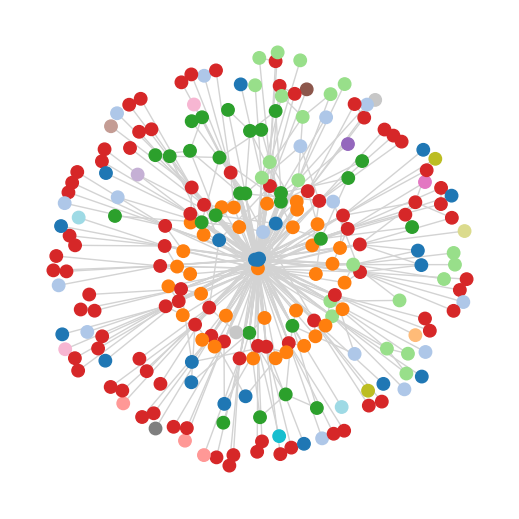

In [90]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Construir diccionario nodo → comunidad a partir de all_communities_lists
comunidad_dict = {
    nodo: comunidad for comunidad, nodos in all_communities_lists.items() for nodo in nodos
}

# Convertir idCarpeta a URIs tipo http://localhost/8730058
idCarpetas_str = [f"http://localhost/{int(x)}" for x in gdfg['idCarpeta'].dropna().unique()]
max_vecinos=2
# Obtener nodos y sus vecinos
nodos_subgrafo = set()
for nodo in idCarpetas_str:
    if nodo in G:
        nodos_subgrafo.add(nodo)
        vecinos = list(G.neighbors(nodo))[:max_vecinos]  # limitar vecinos
        nodos_subgrafo.update(G.neighbors(nodo))
    else:
        print(f"⚠️ Nodo no encontrado en el grafo: {nodo}")

# Crear subgrafo
subG = G.subgraph(nodos_subgrafo).copy()

# Colores por comunidad
comunidades_presentes = sorted({comunidad_dict[n] for n in subG.nodes if n in comunidad_dict})
cmap = cm.get_cmap("tab20", len(comunidades_presentes))
com_id_map = {com: i for i, com in enumerate(comunidades_presentes)}

node_colors = [
    cmap(com_id_map[comunidad_dict[n]]) if n in comunidad_dict else (0.7, 0.7, 0.7)
    for n in subG.nodes()
]

# Dibujar
pos = nx.spring_layout(subG, seed=SEED)

plt.figure(figsize=(5, 5))
nx.draw(
    subG, pos,
    node_color=node_colors,
    edge_color='lightgray',
    node_size=80,
    with_labels=False
)
#plt.title("Subgrafo (idCarpeta + vecinos), coloreado por comunidad")
plt.axis('off')
plt.tight_layout()
plt.savefig("results1_1.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [80]:
comunidades_presentes

[0,
 1,
 5,
 6,
 9,
 10,
 11,
 12,
 13,
 20,
 23,
 26,
 27,
 28,
 32,
 44,
 48,
 57,
 58,
 59,
 62,
 68]

In [96]:
nodossub=list(subG.nodes)

In [97]:
nodossub

['24.0',
 '2020-09-27',
 "(array('d', [-99.05775]), array('d', [19.38437]))",
 "(array('d', [-99.130078550456]), array('d', [19.3646418655562]))",
 'http://localhost/AGEB4147',
 "(array('d', [-99.0402985342443]), array('d', [19.3905383685027]))",
 'http://localhost/8655300',
 'http://localhost/8763141',
 "(array('d', [-98.98873]), array('d', [19.35044]))",
 '41.0',
 "(array('d', [-99.0804858000842]), array('d', [19.2964839973664]))",
 'http://localhost/9091256',
 '28.0',
 'http://localhost/AGEB383A',
 "(array('d', [-99.12261]), array('d', [19.36905]))",
 '39.0',
 'http://localhost/SANTA_CRUZ_MEYEHUALCO_(U_HAB)_I_IZTAPALAPA',
 'http://localhost/AGEB4062',
 '2020-08-19',
 'http://localhost/8741629',
 'http://localhost/AGEB1424',
 "(array('d', [-99.0644829441003]), array('d', [19.3366110229031]))",
 'http://localhost/AGEB3971',
 "(array('d', [-99.0635436798237]), array('d', [19.3248703717973]))",
 'http://localhost/AGEB038A',
 '56.0',
 "(array('d', [-99.0353820416334]), array('d', [19.346

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_30040\2764498064.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", len(comunidades_presentes))  # opción más elegante
C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_30040\2764498064.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


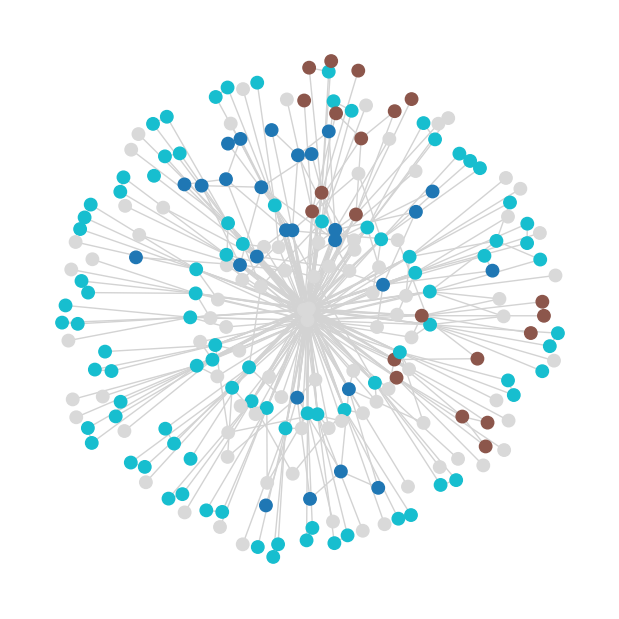

In [113]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Diccionario nodo → comunidad
comunidad_dict = {
    nodo: comunidad for comunidad, nodos in all_communities_lists.items() for nodo in nodos
}

# 2. Convertir idCarpeta a URIs
idCarpetas_str = [f"http://localhost/{int(x)}" for x in gdfg['idCarpeta'].dropna().unique()]

# 3. Construir subgrafo con vecinos
nodos_subgrafo = set()
for nodo in idCarpetas_str:
    if nodo in G:
        nodos_subgrafo.add(nodo)
        nodos_subgrafo.update(G.neighbors(nodo))
    else:
        print(f"⚠️ Nodo no encontrado en el grafo: {nodo}")

subG = G.subgraph(nodos_subgrafo).copy()

# 4. Comunidades que queremos destacar
comunidades_deseadas = set(gdfg['comunidad'].dropna().unique())

# 5. Comunidades presentes en subgrafo
comunidades_presentes = sorted(set(comunidad_dict.get(n) for n in subG.nodes if comunidad_dict.get(n) in comunidades_deseadas))

# 6. Crear colormap solo para comunidades deseadas
cmap = cm.get_cmap("tab10", len(comunidades_presentes))  # opción más elegante

com_id_map = {com: i for i, com in enumerate(comunidades_presentes)}

# 7. Asignar colores a nodos
node_colors = []
for n in subG.nodes():
    com = comunidad_dict.get(n)
    if com in comunidades_deseadas:
        color = cmap(com_id_map[com])  # color por comunidad
    else:
        color = (0.85, 0.85, 0.85)  # gris claro para nodos no destacados
    node_colors.append(color)

# 8. Layout y dibujo
pos = nx.spring_layout(subG, seed=SEED)

plt.figure(figsize=(6, 6))
nx.draw(
    subG, pos,
    node_color=node_colors,
    edge_color='lightgray',
    node_size=80,
    with_labels=False
)

plt.axis('off')
plt.tight_layout()
plt.savefig("grafo_con_comunidades_destacadas.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [114]:
# 1. Filtrar solo los que son URLs de idCarpeta numéricos
idCarpeta_urls = [item for item in nodossub if re.match(r'^http://localhost/\d+$', item)]

# 2. Extraer solo el número y convertir a float
idCarpeta_floats = [float(item.split('/')[-1]) for item in idCarpeta_urls]

# 3. Filtrar gdf
# Suponiendo que gdf tiene una columna llamada 'idCarpeta' con valores numéricos
filtrado = gdfg[gdfg['idCarpeta'].isin(idCarpeta_floats)]

In [115]:
gdfg.comunidad.unique()

array([10, 11, 12], dtype=object)

In [116]:
idCarpeta_urls

['http://localhost/8655300',
 'http://localhost/8763141',
 'http://localhost/9091256',
 'http://localhost/8741629',
 'http://localhost/8438490',
 'http://localhost/8761956',
 'http://localhost/8415500',
 'http://localhost/8733844',
 'http://localhost/8766054',
 'http://localhost/9347345',
 'http://localhost/8537342',
 'http://localhost/9257068',
 'http://localhost/8404858',
 'http://localhost/9003218',
 'http://localhost/8717406',
 'http://localhost/8499625',
 'http://localhost/8717117',
 'http://localhost/8470059',
 'http://localhost/8610022',
 'http://localhost/9256314',
 'http://localhost/8830493',
 'http://localhost/8416607',
 'http://localhost/9056593',
 'http://localhost/8560862',
 'http://localhost/9332821',
 'http://localhost/9268732',
 'http://localhost/9233233',
 'http://localhost/8418236',
 'http://localhost/8701810',
 'http://localhost/9220001',
 'http://localhost/8873036',
 'http://localhost/8371105',
 'http://localhost/9049647',
 'http://localhost/8726268',
 'http://local

In [117]:
# Agregar color por comunidad en gdfg
gdfg['color'] = gdfg['comunidad'].map(lambda c: cmap(com_id_map[c]) if c in com_id_map else (0.7, 0.7, 0.7))


C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


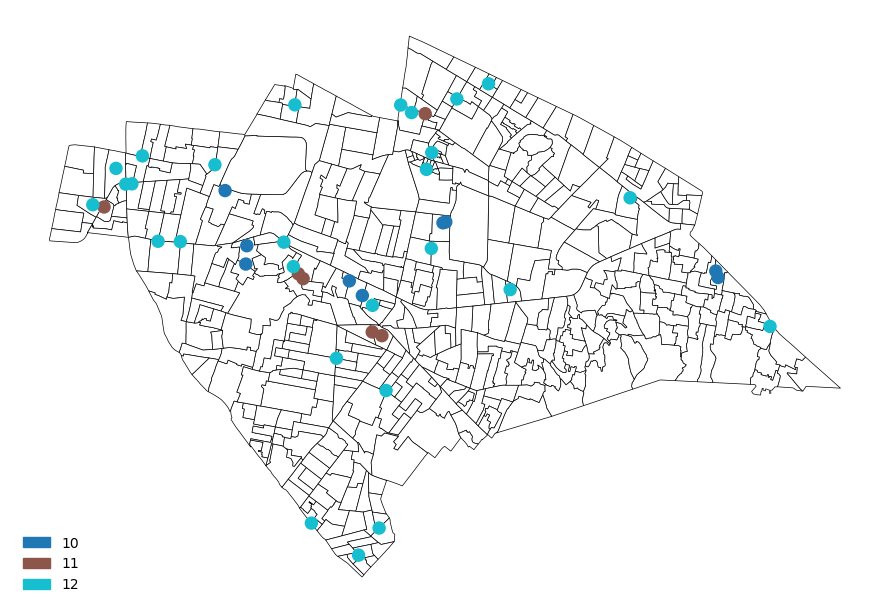

In [119]:
fig,ax=plt.subplots(figsize=(9,11))
alcal[alcal['CVEGEO'].str.contains('09007')].plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
# Tus puntos con color fijo
gdfg.plot(ax=ax, color=gdfg['color'], markersize=75)

# Opcional: leyenda de comunidades
import matplotlib.patches as mpatches

leyenda = [
    mpatches.Patch(color=cmap(com_id_map[com]), label=com)
    for com in comunidades_presentes
]
legend = ax.legend(handles=leyenda, loc='lower left')

# Quitar el marco
legend.get_frame().set_linewidth(0)  # quita el borde
legend.get_frame().set_facecolor('none')  # opcional: fondo transparente
plt.axis('off')
plt.tight_layout()
plt.savefig("results1_2.jpg", format='jpg', dpi=300, bbox_inches='tight')

In [386]:
gdfg.comunidad.unique()

array([3, 4, 5, 6, 7], dtype=object)

In [284]:
gdf2=gdfg[gdfg['comunidad']==5]
gdf2

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
198         282.0   54289.0     54916.0  8399228.0      2019.0      Abril   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   
205         196.0   37536.0     38000.0  8501840.0      2019.0     Agosto   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
198  2019-04-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
205  2019-08-20  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  shp longitudrad latitudrad grupo_etario  grupo_etario2 genero2  \
197  ...  NaN   -1.729488   0.337997        19-64              2     1.0   
198  ...  NaN   -1.728215   0.337732        19-64              2     1.0   
199  ...  NaN   -1.729136   0.336928        19-64              2     1.0   
200  ...  NaN   -1.729856   0.337984        19-64              2     1.0   
201  ...  NaN   -1.729975   0.337900        19-64              2     2.0   
202  ...  NaN   -1.728621   0.337723        19-64              2     1.0   
203  ...  NaN   -1.730292   0.337949        19-64              2     1.0   
204  ...  NaN   -1.729103   0.337503        19-64              2     1.0   
205  ...  NaN   -1.728947   0.337603        19-64              2     1.0   

        año comunidad                    geometry  \
197  2020.0         5  POINT (-99.09234 19.36582)   
198  2019.0         5  POINT (-99.01944 19.35060)   
199  2021.0         5  POINT (-99.07217 19.30454)   
200  2020.0         5  POINT (-99.11344 19.36507)   
201  2021.0         5  POINT (-99.12028 19.36027)   
202  2022.0         5  POINT (-99.04266 19.35008)   
203  2021.0         5  POINT (-99.13843 19.36306)   
204  2021.0         5  POINT (-99.07033 19.33751)   
205  2019.0         5  POINT (-99.06136 19.34324)   

                                                 color  
197  (0.5490196078431373, 0.33725490196078434, 0.29...  
198  (0.5490196078431373, 0.33725490196078434, 0.29...  
199  (0.5490196078431373, 0.33725490196078434, 0.29...  
200  (0.5490196078431373, 0.33725490196078434, 0.29...  
201  (0.5490196078431373, 0.33725490196078434, 0.29...  
202  (0.5490196078431373, 0.33725490196078434, 0.29...  
203  (0.5490196078431373, 0.33725490196078434, 0.29...  
204  (0.5490196078431373, 0.33725490196078434, 0.29...  
205  (0.5490196078431373, 0.33725490196078434, 0.29...  

[9 rows x 36 columns]

In [285]:
gdf2['CVE'] = None
gdf2['pobreza'] = None

for i in range(len(gdf2)):
    punto = gdf2.geometry.iloc[i]
    idx = gdf2.index[i]  # índice real en el DataFrame

    for j in range(len(alcal)):
        pobre = alcal.POBREZA.iloc[j]
        geom = alcal.geometry.iloc[j]
        clave = alcal.CVEGEO.iloc[j]

        if geom.contains(punto):
            gdf2.at[idx, 'CVE'] = clave
            gdf2.at[idx, 'pobreza'] = pobre
            break


C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [286]:
gdf2

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
198         282.0   54289.0     54916.0  8399228.0      2019.0      Abril   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   
205         196.0   37536.0     38000.0  8501840.0      2019.0     Agosto   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
198  2019-04-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
205  2019-08-20  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  latitudrad grupo_etario grupo_etario2 genero2     año comunidad  \
197  ...    0.337997        19-64             2     1.0  2020.0         5   
198  ...    0.337732        19-64             2     1.0  2019.0         5   
199  ...    0.336928        19-64             2     1.0  2021.0         5   
200  ...    0.337984        19-64             2     1.0  2020.0         5   
201  ...    0.337900        19-64             2     2.0  2021.0         5   
202  ...    0.337723        19-64             2     1.0  2022.0         5   
203  ...    0.337949        19-64             2     1.0  2021.0         5   
204  ...    0.337503        19-64             2     1.0  2021.0         5   
205  ...    0.337603        19-64             2     1.0  2019.0         5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
198  POINT (-99.01944 19.35060)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
201  POINT (-99.12028 19.36027)   
202  POINT (-99.04266 19.35008)   
203  POINT (-99.13843 19.36306)   
204  POINT (-99.07033 19.33751)   
205  POINT (-99.06136 19.34324)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
198  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011710   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
201  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
203  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   
205  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011621   

      pobreza  
197  (18, 34]  
198  (34, 50]  
199  (34, 50]  
200  (18, 34]  
201  [ 0, 18]  
202  (50, 70]  
203  [ 0, 18]  
204  (34, 50]  
205  (34, 50]  

[9 rows x 38 columns]

In [60]:
gdf2['pobreza']=''
gdf2['CVE']=''
for i in range(0,len(alcal)):
    geom=alcal.geometry.iloc[i]
    pobre=alcal.POBREZA.iloc[i]
    cve=alcal.CVEGEO.iloc[i]
    for j in range(0,len(gdf2)):
        punto=gdf2.geometry.iloc[j]
        if geom.contains(punto):
            gdf2.loc[gdf2['geometry']==punto,'pobreza']= pobre
            gdf2.loc[gdf2['geometry']==punto,'CVE']= cve

In [287]:
gdf2

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
198         282.0   54289.0     54916.0  8399228.0      2019.0      Abril   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   
205         196.0   37536.0     38000.0  8501840.0      2019.0     Agosto   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
198  2019-04-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
205  2019-08-20  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  latitudrad grupo_etario grupo_etario2 genero2     año comunidad  \
197  ...    0.337997        19-64             2     1.0  2020.0         5   
198  ...    0.337732        19-64             2     1.0  2019.0         5   
199  ...    0.336928        19-64             2     1.0  2021.0         5   
200  ...    0.337984        19-64             2     1.0  2020.0         5   
201  ...    0.337900        19-64             2     2.0  2021.0         5   
202  ...    0.337723        19-64             2     1.0  2022.0         5   
203  ...    0.337949        19-64             2     1.0  2021.0         5   
204  ...    0.337503        19-64             2     1.0  2021.0         5   
205  ...    0.337603        19-64             2     1.0  2019.0         5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
198  POINT (-99.01944 19.35060)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
201  POINT (-99.12028 19.36027)   
202  POINT (-99.04266 19.35008)   
203  POINT (-99.13843 19.36306)   
204  POINT (-99.07033 19.33751)   
205  POINT (-99.06136 19.34324)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
198  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011710   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
201  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
203  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   
205  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011621   

      pobreza  
197  (18, 34]  
198  (34, 50]  
199  (34, 50]  
200  (18, 34]  
201  [ 0, 18]  
202  (50, 70]  
203  [ 0, 18]  
204  (34, 50]  
205  (34, 50]  

[9 rows x 38 columns]

In [289]:
gdf2=gdf2[gdf2['pobreza']!='']

In [290]:
gdf2.pobreza.unique()

array(['(18, 34]', '(34, 50]', '[ 0, 18]', '(50, 70]'], dtype=object)

# Nueva forma de agregar

gdf2['pobreza'].value_counts()

In [308]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from geopy.distance import geodesic


def geod_distance(p1, p2):
    return geodesic((p1.y, p1.x), (p2.y, p2.x)).kilometers

# Calcular la matriz de distancias geodésicas
dist_matrix_geod = [
    [geod_distance(p1, p2) for p2 in gdf2['geometry']]
    for p1 in gdf2['geometry']
]

# Convertir la matriz a un DataFrame
dist_matrix_df = pd.DataFrame(dist_matrix_geod, index=gdf2.idCarpeta, columns=gdf2.idCarpeta)

dist_matrix_df


idCarpeta  8632653.0  8399228.0  8849170.0  8657148.0  9062831.0  9164291.0  \
idCarpeta                                                                     
8632653.0   0.000000   7.841970   7.107019   2.218748   2.999785   5.501964   
8399228.0   7.841970   0.000000   7.530068  10.005126  10.649134   2.440917   
8849170.0   7.107019   7.530068   0.000000   7.981290   7.976102   5.918319   
8657148.0   2.218748  10.005126   7.981290   0.000000   0.893918   7.618865   
9062831.0   2.999785  10.649134   7.976102   0.893918   0.000000   8.232703   
9164291.0   5.501964   2.440917   5.918319   7.618865   8.232703   0.000000   
8843659.0   4.852356  12.577702   9.510335   2.634918   1.931552  10.163820   
9070654.0   3.894724   5.540404   3.654547   5.460989   5.821820   3.223088   
8501840.0   4.103694   4.479330   4.432201   5.981622   6.471552   2.105153   

idCarpeta  8843659.0  9070654.0  8501840.0  
idCarpeta                                   
8632653.0   4.852356   3.894724   4.103694  
8399228.0  12.577702   5.540404   4.479330  
8849170.0   9.510335   3.654547   4.432201  
8657148.0   2.634918   5.460989   5.981622  
9062831.0   1.931552   5.821820   6.471552  
9164291.0  10.163820   3.223088   2.105153  
8843659.0   0.000000   7.693965   8.389642  
9070654.0   7.693965   0.000000   1.136529  
8501840.0   8.389642   1.136529   0.000000

In [309]:

gdf2['IDS']=gdf2.idCarpeta.values
gdf2

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
198         282.0   54289.0     54916.0  8399228.0      2019.0      Abril   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   
205         196.0   37536.0     38000.0  8501840.0      2019.0     Agosto   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
198  2019-04-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
205  2019-08-20  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
197  ...         19-64             2     1.0  2020.0          5   
198  ...         19-64             2     1.0  2019.0          5   
199  ...         19-64             2     1.0  2021.0          5   
200  ...         19-64             2     1.0  2020.0          5   
201  ...         19-64             2     2.0  2021.0          5   
202  ...         19-64             2     1.0  2022.0          5   
203  ...         19-64             2     1.0  2021.0          5   
204  ...         19-64             2     1.0  2021.0          5   
205  ...         19-64             2     1.0  2019.0          5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
198  POINT (-99.01944 19.35060)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
201  POINT (-99.12028 19.36027)   
202  POINT (-99.04266 19.35008)   
203  POINT (-99.13843 19.36306)   
204  POINT (-99.07033 19.33751)   
205  POINT (-99.06136 19.34324)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
198  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011710   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
201  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
203  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   
205  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011621   

      pobreza        IDS  
197  (18, 34]  8632653.0  
198  (34, 50]  8399228.0  
199  (34, 50]  8849170.0  
200  (18, 34]  8657148.0  
201  [ 0, 18]  9062831.0  
202  (50, 70]  9164291.0  
203  [ 0, 18]  8843659.0  
204  (34, 50]  9070654.0  
205  (34, 50]  8501840.0  

[9 rows x 39 columns]

In [310]:
import numpy as np

def find_central_point_by_community(gdf, dist_matrix_df):
    """
    Encuentra el punto central en la comunidad con el número máximo de elementos
    considerando una matriz de distancias.
    
    Args:
    - gdf (GeoDataFrame): GeoDataFrame con una columna 'comunidad' que agrupa los puntos.
    - dist_matrix_df (DataFrame): Matriz de distancias entre los índices de gdf.

    Returns:
    - central_point (list): [índice del punto central, comunidad asociada].
    """
    # Agrupar por 'comunidad' y contar el número de elementos por comunidad
    groups = gdf.groupby('CVE').count()

    # Encontrar el valor máximo y su índice correspondiente
    max_count = groups.max().max()  # Obtiene el valor máximo global
    max_group = groups[groups == max_count].dropna()  # Filtra las filas correspondientes al valor máximo
    indices = max_group.index.values  # Obtener los índices de comunidades con el valor máximo
    print("Índices con el valor máximo:", indices)

    # Inicializar variables para encontrar el punto central
    min_avg_distance = np.inf
    central_point = None

    # Iterar sobre los índices de las comunidades con el máximo valor
    for i in indices:
        # Filtrar los datos correspondientes a la comunidad actual
        dat = gdf[gdf['CVE'] == i]
        identifi = dat.index.values.tolist()  # Obtener los identificadores de los puntos

        # Calcular la distancia promedio para cada punto en esta comunidad
        for k in range(len(identifi)):
            ind1 = identifi[k]
            avg_distance = np.mean(
                [dist_matrix_df.loc[ind1, identifi[j]] for j in range(len(identifi)) if k != j]
            )
            # Actualizar el punto central si la distancia promedio es menor
            if avg_distance < min_avg_distance:
                min_avg_distance = avg_distance
                central_point = [ind1, i]

    return central_point


In [321]:
central_point = find_central_point_by_community(gdf2, dist_matrix_df)
print("Punto central:", central_point)

# Acceder a las coordenadas o datos del punto central
if central_point:
    print("Datos del punto central:")
    print(gdf2.loc[central_point[0]])


Índices con el valor máximo: []
Punto central: None


In [313]:
poblacion=gpd.read_file('total.shp')

ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [314]:
poblacion['ageb']=poblacion.ageb.str[-4:]

In [315]:
poblacion.head()

alc             loc amb_loc  ageb     pob  p_3ymas  p_12yms  \
0  Álvaro Obregón  Álvaro Obregón  Urbana  1716  7042.0   6811.0   5896.0   
1  Álvaro Obregón  Álvaro Obregón  Urbana  2150  4588.0   4487.0   4062.0   
2  Álvaro Obregón  Álvaro Obregón  Urbana  1133  2203.0   2179.0   2025.0   
3  Álvaro Obregón  Álvaro Obregón  Urbana  1307  2914.0   2859.0   2628.0   
4  Álvaro Obregón  Álvaro Obregón  Urbana  0281   237.0    234.0    204.0   

   p_nacoe  p_vivoe  p_hli  ...   t_hli_h   t_afrmx  t_p12ym_sl  t_p12ym_c  \
0   1420.0    134.0  170.0  ...  2.451916  0.908833   34.107870  50.661465   
1    672.0    142.0   26.0  ...  0.579452  1.307759   39.217134  44.780896   
2    473.0    119.0   25.0  ...  1.101423  1.497957   39.111111  43.407407   
3    657.0    175.0   86.0  ...  2.973068  0.754976   41.400304  48.439878   
4     53.0     23.0    6.0  ...  2.564103  2.531646   39.705882  48.529412   

   t_p12ym_sp    t_catlc   t_criev   t_trsrl    t_sinrl  \
0   15.213704  79.011644  6.617438  0.085203  14.257313   
1   15.952733  79.707934  5.732345  0.566696  13.949433   
2   16.049383  67.362687  5.991829  0.862460  24.148888   
3    9.931507  84.179822  3.294441  0.411805  11.873713   
4   11.274510  81.012658       NaN  2.953586  14.767932   

                                            geometry  
0  POLYGON ((-99.25882 19.32558, -99.25834 19.325...  
1  POLYGON ((-99.19170 19.37893, -99.19170 19.378...  
2  POLYGON ((-99.17760 19.35182, -99.17766 19.351...  
3  POLYGON ((-99.20805 19.31277, -99.20768 19.312...  
4  POLYGON ((-99.24228 19.38451, -99.24233 19.384...  

[5 rows x 34 columns]

In [316]:
mean_distance = dist_matrix_df.values.mean()
print("Media general:", mean_distance)

Media general: 5.1598980542486075


In [317]:
#mean_pob = poblacion.pob.mean()
#std_pob =poblacion.pob.std()

###lim_inf_pob = mean_pob - std_pob
###lim_sup_pob = mean_pob + std_pob

In [318]:
"""dftest1['poblacion']=''
for i in range(0,len(dftest1)):
    row=dftest1.iloc[i]
    ag=row['ageb']
    pop=poblacion[poblacion['ageb']==ag]
    if len(pop) > 0:
        dftest1['poblacion'].iloc[i]=pop['pob'].values[0]
    else:
        dftest1['poblacion'].iloc[i]=0"""

"dftest1['poblacion']=''\nfor i in range(0,len(dftest1)):\n    row=dftest1.iloc[i]\n    ag=row['ageb']\n    pop=poblacion[poblacion['ageb']==ag]\n    if len(pop) > 0:\n        dftest1['poblacion'].iloc[i]=pop['pob'].values[0]\n    else:\n        dftest1['poblacion'].iloc[i]=0"

In [322]:
gdf2

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
198         282.0   54289.0     54916.0  8399228.0      2019.0      Abril   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   
205         196.0   37536.0     38000.0  8501840.0      2019.0     Agosto   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
198  2019-04-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
205  2019-08-20  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
197  ...         19-64             2     1.0  2020.0          5   
198  ...         19-64             2     1.0  2019.0          5   
199  ...         19-64             2     1.0  2021.0          5   
200  ...         19-64             2     1.0  2020.0          5   
201  ...         19-64             2     2.0  2021.0          5   
202  ...         19-64             2     1.0  2022.0          5   
203  ...         19-64             2     1.0  2021.0          5   
204  ...         19-64             2     1.0  2021.0          5   
205  ...         19-64             2     1.0  2019.0          5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
198  POINT (-99.01944 19.35060)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
201  POINT (-99.12028 19.36027)   
202  POINT (-99.04266 19.35008)   
203  POINT (-99.13843 19.36306)   
204  POINT (-99.07033 19.33751)   
205  POINT (-99.06136 19.34324)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
198  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011710   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
201  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
203  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   
205  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011621   

      pobreza        IDS  
197  (18, 34]  8632653.0  
198  (34, 50]  8399228.0  
199  (34, 50]  8849170.0  
200  (18, 34]  8657148.0  
201  [ 0, 18]  9062831.0  
202  (50, 70]  9164291.0  
203  [ 0, 18]  8843659.0  
204  (34, 50]  9070654.0  
205  (34, 50]  8501840.0  

[9 rows x 39 columns]

<Axes: >

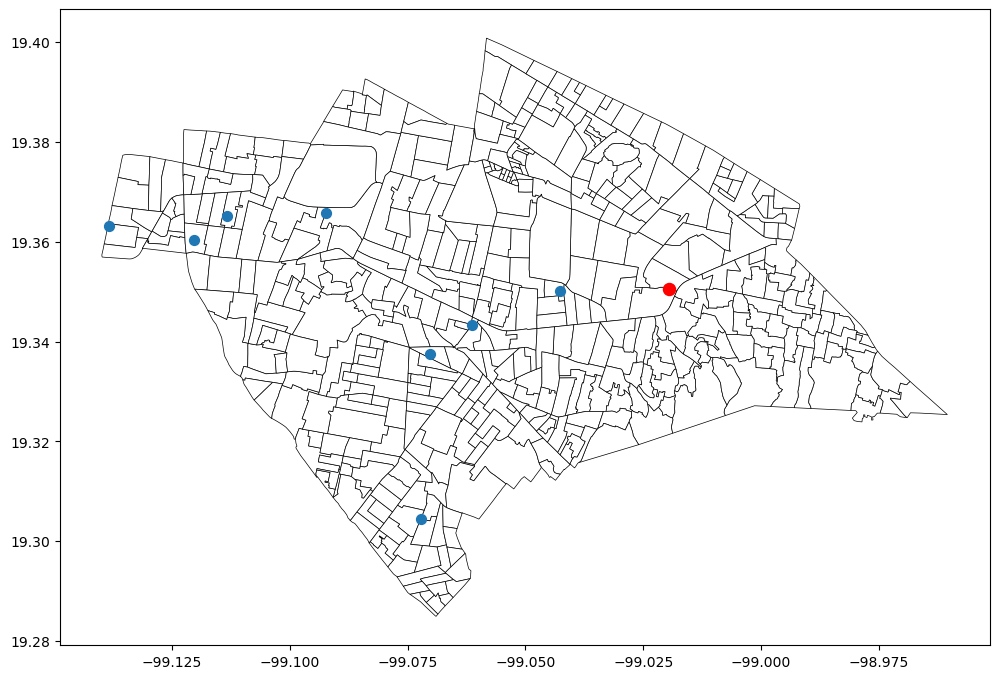

In [325]:
fig,ax=plt.subplots(figsize=(12,10))
iztapa.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
root=gdf2[gdf2['IDS']==8399228.0]
#root=root[root['comunidad']==central_points[0]]
gdf2.plot(ax=ax,markersize=50,legend=True,categorical=True)
root.plot(ax=ax,markersize=75,color='red')


In [326]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'idCarpeta', 'Año_inicio',
       'Mes_inicio', 'FechaInicio', 'Delito', 'Categoria', 'Sexo', 'Edad',
       'TipoPersona', 'CalidadJuridica', 'competencia', 'Año_hecho',
       'Mes_hecho', 'FechaHecho', 'HoraHecho', 'HoraInicio', 'alcaldia_hechos',
       'municipio_hechos', 'colonia_datos', 'fgj_colonia_registro', 'latitud',
       'longitud', 'ageb', 'shp', 'longitudrad', 'latitudrad', 'grupo_etario',
       'grupo_etario2', 'genero2', 'año', 'comunidad', 'geometry', 'color',
       'CVE', 'pobreza', 'IDS'],
      dtype='object')

In [327]:

grupo

Unnamed: 0.1    index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
198         282.0  54289.0     54916.0  8399228.0      2019.0      Abril   

    FechaInicio                       Delito         Categoria       Sexo  \
198  2019-04-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
198  ...         19-64             2     1.0  2019.0          5   

                       geometry  \
198  POINT (-99.01944 19.35060)   

                                                 color            CVE  \
198  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011710   

      pobreza        IDS  
198  (34, 50]  8399228.0  

[1 rows x 39 columns]

In [328]:
gdf3=gdf2[gdf2['CVE'] != '0900700011710']
gdf3
#dftest2

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   
205         196.0   37536.0     38000.0  8501840.0      2019.0     Agosto   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
205  2019-08-20  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
197  ...         19-64             2     1.0  2020.0          5   
199  ...         19-64             2     1.0  2021.0          5   
200  ...         19-64             2     1.0  2020.0          5   
201  ...         19-64             2     2.0  2021.0          5   
202  ...         19-64             2     1.0  2022.0          5   
203  ...         19-64             2     1.0  2021.0          5   
204  ...         19-64             2     1.0  2021.0          5   
205  ...         19-64             2     1.0  2019.0          5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
201  POINT (-99.12028 19.36027)   
202  POINT (-99.04266 19.35008)   
203  POINT (-99.13843 19.36306)   
204  POINT (-99.07033 19.33751)   
205  POINT (-99.06136 19.34324)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
201  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
203  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   
205  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011621   

      pobreza        IDS  
197  (18, 34]  8632653.0  
199  (34, 50]  8849170.0  
200  (18, 34]  8657148.0  
201  [ 0, 18]  9062831.0  
202  (50, 70]  9164291.0  
203  [ 0, 18]  8843659.0  
204  (34, 50]  9070654.0  
205  (34, 50]  8501840.0  

[8 rows x 39 columns]

In [329]:
listapobreza=[]
listapobreza.extend(grupo['pobreza'].mode())

In [330]:
listapobreza

['(34, 50]']

In [331]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos

# Inicializa la columna 'pop_range' en dftest2
#dftest2['pop_range'] = ''

# Itera sobre las filas de dftest2
dftest2=gdf3.copy()
for i in range(len(dftest2)):
    row2 = dftest2.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):

            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



   Unnamed: 0.1    index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0         282.0  54289.0     54916.0  8399228.0      2019.0      Abril   
1         196.0  37536.0     38000.0  8501840.0      2019.0     Agosto   

  FechaInicio                       Delito         Categoria       Sexo  ...  \
0  2019-04-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
1  2019-08-20  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   

   grupo_etario grupo_etario2 genero2     año  comunidad  \
0         19-64             2     1.0  2019.0          5   
1         19-64             2     1.0  2019.0          5   

                     geometry  \
0  POINT (-99.01944 19.35060)   
1  POINT (-99.06136 19.34324)   

                                               color            CVE   pobreza  \
0  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011710  (34, 50]   
1  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011621  (34, 50]   

         ID

In [332]:
grupo['pobreza'].unique().tolist()

['(34, 50]']

In [333]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

2

In [334]:
dftest3 = dftest2[~dftest2['IDS'].isin(listaids)]
dftest3['pobreza'].unique()

array(['(18, 34]', '(34, 50]', '[ 0, 18]', '(50, 70]'], dtype=object)

In [382]:
dftest3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7 entries, 197 to 204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Unnamed: 0.1          7 non-null      float64 
 1   index                 7 non-null      float64 
 2   Unnamed: 0            7 non-null      float64 
 3   idCarpeta             7 non-null      float64 
 4   Año_inicio            7 non-null      float64 
 5   Mes_inicio            7 non-null      object  
 6   FechaInicio           7 non-null      object  
 7   Delito                7 non-null      object  
 8   Categoria             7 non-null      object  
 9   Sexo                  7 non-null      object  
 10  Edad                  7 non-null      float64 
 11  TipoPersona           7 non-null      object  
 12  CalidadJuridica       7 non-null      object  
 13  competencia           7 non-null      object  
 14  Año_hecho             7 non-null      float64 
 15  Mes

<Axes: >

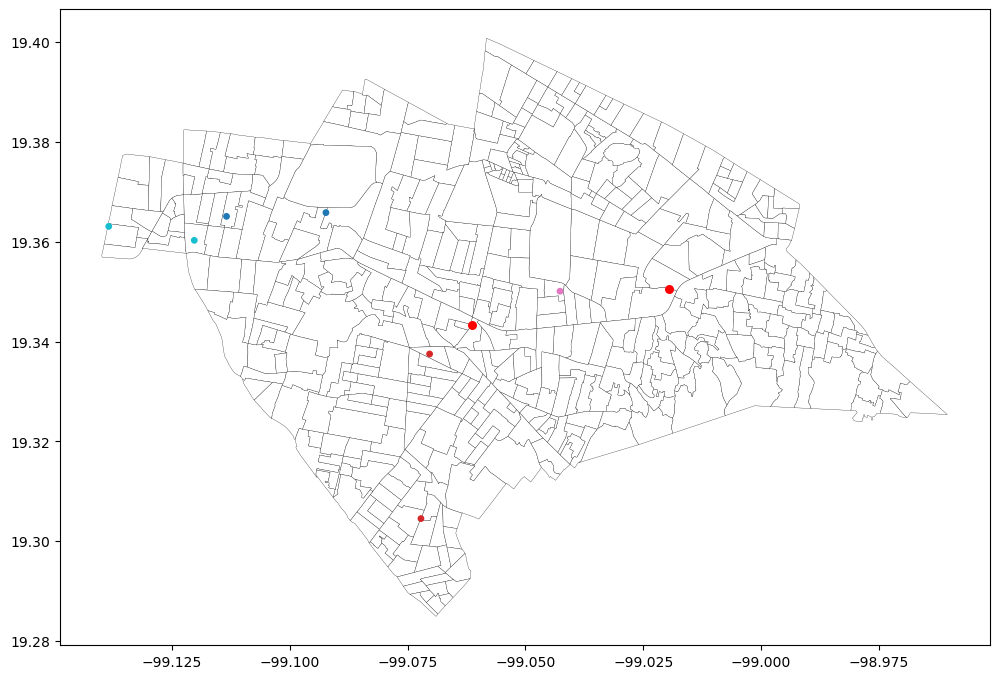

In [337]:
fig,ax=plt.subplots(figsize=(12,10))
iztapa.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest3.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [338]:
grupo['newgroup']=1

In [339]:
alcal

CVEGEO   POBREZA POBREZAEX    ID  \
0     0900200010010  (18, 34]  [ 0, 20]     1   
1     0900200010025  [ 0, 18]  [ 0, 20]     2   
2     090020001003A  [ 0, 18]  [ 0, 20]     3   
3     0900200010044  [ 0, 18]  [ 0, 20]     4   
4     0900200010097  [ 0, 18]  [ 0, 20]     5   
...             ...       ...       ...   ...   
2427  0901700011488  (34, 50]  [ 0, 20]  2428   
2428  0901700011492  (34, 50]  [ 0, 20]  2429   
2429  0901700011505  [ 0, 18]  [ 0, 20]  2430   
2430  090170001151A  (18, 34]  [ 0, 20]  2431   
2431  0901700011524  (34, 50]  [ 0, 20]  2432   

                                               geometry  
0     POLYGON ((-99.20307 19.51415, -99.20319 19.513...  
1     POLYGON ((-99.19662 19.51270, -99.19662 19.511...  
2     POLYGON ((-99.20658 19.51169, -99.20611 19.511...  
3     POLYGON ((-99.20530 19.51033, -99.20529 19.510...  
4     POLYGON ((-99.20573 19.50454, -99.20630 19.504...  
...                                                 ...  
2427  POLYGON ((-99.05931 19.42789, -99.05934 19.427...  
2428  POLYGON ((-99.05931 19.42789, -99.05794 19.426...  
2429  POLYGON ((-99.06102 19.42776, -99.05995 19.426...  
2430  POLYGON ((-99.06253 19.42663, -99.06281 19.426...  
2431  POLYGON ((-99.05709 19.42377, -99.05723 19.422...  

[2432 rows x 5 columns]

In [341]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo1 = gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()
iztapa['cluster']=''
# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(iztapa)):
    row2 = iztapa.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo1 = pd.concat([alcgrupo1, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo1=gpd.GeoDataFrame(alcgrupo1,geometry=alcgrupo1.geometry)

C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_23132\828563774.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


In [342]:
alcgrupo1.cluster.value_counts()

cluster
1    2
Name: count, dtype: int64

In [343]:
alcgrupo1

CVEGEO   POBREZA POBREZAEX   ID  \
0  0900700011621  (34, 50]  [ 0, 20]  833   
1  0900700011710  (34, 50]  [ 0, 20]  842   

                                            geometry  cluster  
0  POLYGON ((-99.06535 19.33905, -99.06501 19.338...        1  
1  POLYGON ((-99.02431 19.35081, -99.02371 19.350...        1

In [344]:
# Crear una columna 'cluster' en alcshp
alcal['cluster'] = ''

# Iterar sobre cada fila de alcgrupo1
for i in range(len(alcgrupo1)):
    row = alcgrupo1.iloc[i]
    ageb = row['CVEGEO']
    cluster_value = row['cluster']
    
    # Buscar la fila correspondiente en alcshp y asignar el valor del cluster
    alcal.loc[alcal['CVEGEO'] == ageb, 'cluster'] = cluster_value


<Axes: >

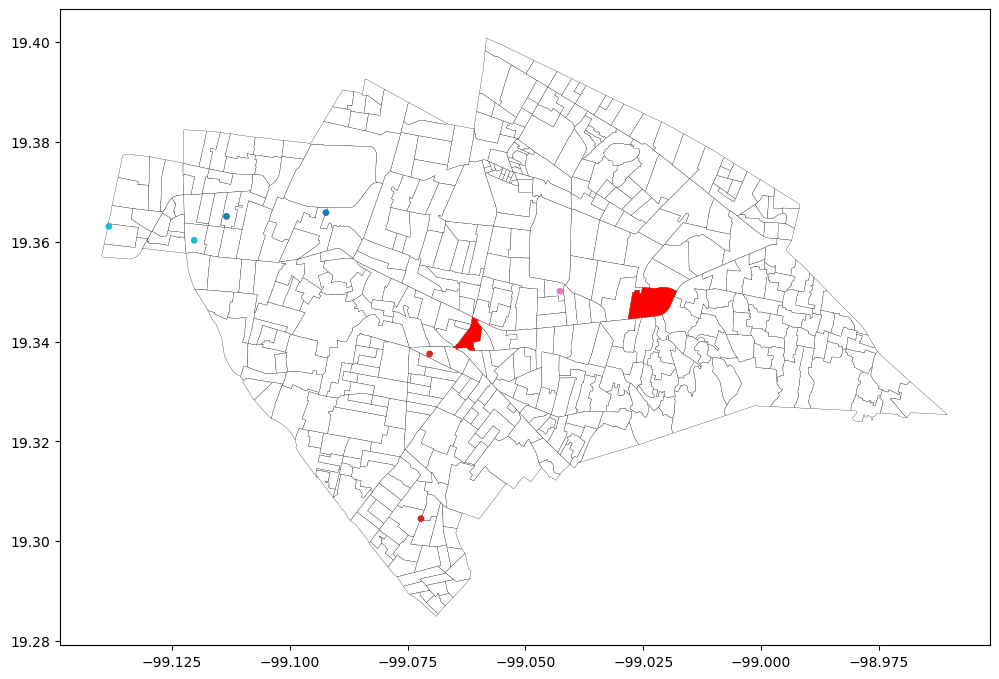

In [346]:
fig,ax=plt.subplots(figsize=(12,10))
iztapa.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo1.plot(ax=ax,color='red')

dftest3.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [347]:
grupo.columns

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'idCarpeta', 'Año_inicio',
       'Mes_inicio', 'FechaInicio', 'Delito', 'Categoria', 'Sexo', 'Edad',
       'TipoPersona', 'CalidadJuridica', 'competencia', 'Año_hecho',
       'Mes_hecho', 'FechaHecho', 'HoraHecho', 'HoraInicio', 'alcaldia_hechos',
       'municipio_hechos', 'colonia_datos', 'fgj_colonia_registro', 'latitud',
       'longitud', 'ageb', 'shp', 'longitudrad', 'latitudrad', 'grupo_etario',
       'grupo_etario2', 'genero2', 'año', 'comunidad', 'geometry', 'color',
       'CVE', 'pobreza', 'IDS', 'newgroup'],
      dtype='object')

In [384]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos

for i in range(len(dftest2)):
    row2 = dftest2.iloc[i]
    ind2 = row2['idCarpeta']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['idCarpeta']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            # Agregar la fila directamente al DataFrame grupo
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)


   Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
1        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
2        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
3        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   

  FechaInicio                       Delito         Categoria       Sexo  ...  \
0  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
1  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
2  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
3  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   

   grupo_etario grupo_etario2 genero2     año  comunidad  \
0         19-64             2     1.0  2020.0          5   
1         19-64             2     1.0  2020.0          5   
2         19-64             2     1.0  2020

In [385]:
pobre=pobre.rename(columns={'Clave de \nAGEB':'CVEGEO'})
pobre

alcshppob=pd.merge(alcshp,pobre,on=['CVEGEO'])

from libpysal.weights import Queen

w_queen = Queen.from_dataframe(alcshppob)

AttributeError: 'str' object has no attribute 'rename'

In [348]:
dftest3['pobreza'].value_counts()

pobreza
(18, 34]    2
(34, 50]    2
[ 0, 18]    2
(50, 70]    1
Name: count, dtype: int64

In [350]:
dftest3

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
197  ...         19-64             2     1.0  2020.0          5   
199  ...         19-64             2     1.0  2021.0          5   
200  ...         19-64             2     1.0  2020.0          5   
201  ...         19-64             2     2.0  2021.0          5   
202  ...         19-64             2     1.0  2022.0          5   
203  ...         19-64             2     1.0  2021.0          5   
204  ...         19-64             2     1.0  2021.0          5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
201  POINT (-99.12028 19.36027)   
202  POINT (-99.04266 19.35008)   
203  POINT (-99.13843 19.36306)   
204  POINT (-99.07033 19.33751)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
201  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
203  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   

      pobreza        IDS  
197  (18, 34]  8632653.0  
199  (34, 50]  8849170.0  
200  (18, 34]  8657148.0  
201  [ 0, 18]  9062831.0  
202  (50, 70]  9164291.0  
203  [ 0, 18]  8843659.0  
204  (34, 50]  9070654.0  

[7 rows x 39 columns]

In [349]:
central_point = find_central_point_by_community(dftest3, dist_matrix_df)
print("Punto central:", central_point)

# Acceder a las coordenadas o datos del punto central
if central_point:
    print("Datos del punto central:")
    print(gdf2.loc[central_point[0]])

Índices con el valor máximo: []
Punto central: None


In [351]:
root=dftest3[dftest3['IDS']==9062831.0]
root

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
201        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   

    FechaInicio                       Delito         Categoria      Sexo  ...  \
201  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Femenino  ...   

     grupo_etario grupo_etario2 genero2     año  comunidad  \
201         19-64             2     2.0  2021.0          5   

                       geometry  \
201  POINT (-99.12028 19.36027)   

                                                 color            CVE  \
201  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939   

      pobreza        IDS  
201  [ 0, 18]  9062831.0  

[1 rows x 39 columns]

<Axes: >

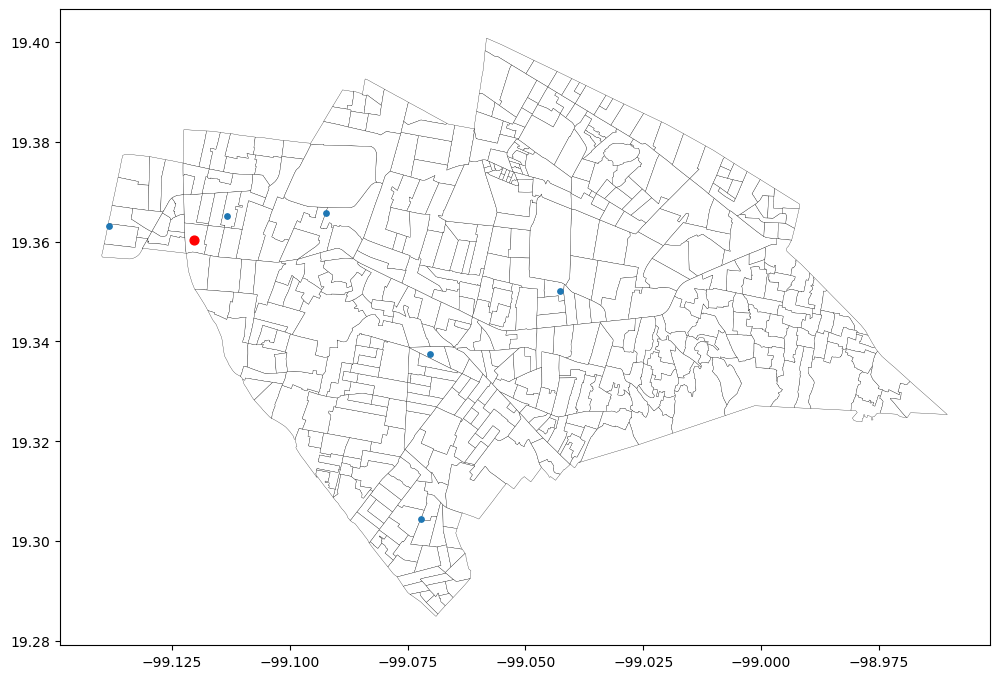

In [352]:
fig,ax=plt.subplots(figsize=(12,10))
iztapa.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest3.plot(ax=ax,markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [353]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'idCarpeta', 'Año_inicio',
       'Mes_inicio', 'FechaInicio', 'Delito', 'Categoria', 'Sexo', 'Edad',
       'TipoPersona', 'CalidadJuridica', 'competencia', 'Año_hecho',
       'Mes_hecho', 'FechaHecho', 'HoraHecho', 'HoraInicio', 'alcaldia_hechos',
       'municipio_hechos', 'colonia_datos', 'fgj_colonia_registro', 'latitud',
       'longitud', 'ageb', 'shp', 'longitudrad', 'latitudrad', 'grupo_etario',
       'grupo_etario2', 'genero2', 'año', 'comunidad', 'geometry', 'color',
       'CVE', 'pobreza', 'IDS'],
      dtype='object')

In [354]:
grupo['pobreza']

201    [ 0, 18]
Name: pobreza, dtype: object

In [355]:
listapobreza

['(34, 50]']

In [356]:
dftest4=dftest3[dftest3['IDS'] != 9062831.0]
dftest4

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
203        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
203  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
197  ...         19-64             2     1.0  2020.0          5   
199  ...         19-64             2     1.0  2021.0          5   
200  ...         19-64             2     1.0  2020.0          5   
202  ...         19-64             2     1.0  2022.0          5   
203  ...         19-64             2     1.0  2021.0          5   
204  ...         19-64             2     1.0  2021.0          5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
202  POINT (-99.04266 19.35008)   
203  POINT (-99.13843 19.36306)   
204  POINT (-99.07033 19.33751)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
203  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   

      pobreza        IDS  
197  (18, 34]  8632653.0  
199  (34, 50]  8849170.0  
200  (18, 34]  8657148.0  
202  (50, 70]  9164291.0  
203  [ 0, 18]  8843659.0  
204  (34, 50]  9070654.0  

[6 rows x 39 columns]

In [357]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest4)):
    row2 = dftest4.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



   Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0        3339.0  685826.0    691817.0  9062831.0      2021.0  Noviembre   
1        2605.0  489902.0    494400.0  8843659.0      2021.0      Enero   

  FechaInicio                       Delito         Categoria       Sexo  ...  \
0  2021-11-18  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino  ...   
1  2021-01-27  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   

   grupo_etario grupo_etario2 genero2     año  comunidad  \
0         19-64             2     2.0  2021.0          5   
1         19-64             2     1.0  2021.0          5   

                     geometry  \
0  POINT (-99.12028 19.36027)   
1  POINT (-99.13843 19.36306)   

                                               color            CVE   pobreza  \
0  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010939  [ 0, 18]   
1  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010801  [ 0, 18]   

        

In [358]:
grupo['pobreza'].unique()

array(['[ 0, 18]'], dtype=object)

In [359]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

2

In [360]:
dftest5 = dftest4[~dftest4['IDS'].isin(listaids)]
dftest5['pobreza'].unique()

array(['(18, 34]', '(34, 50]', '(50, 70]'], dtype=object)

In [361]:
len(grupo)

2

<Axes: >

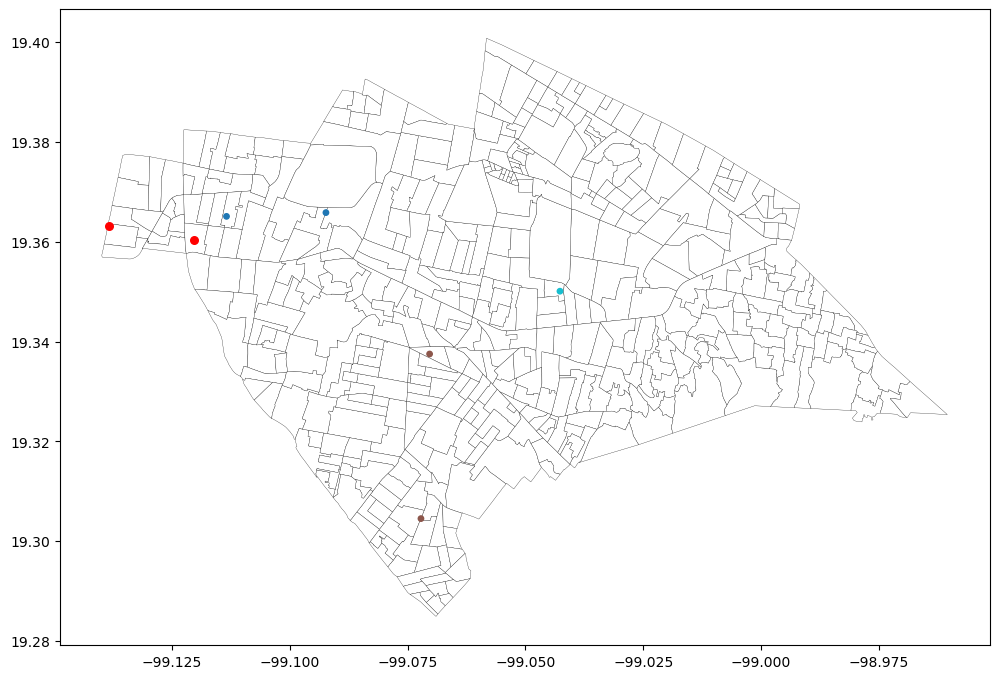

In [362]:
fig,ax=plt.subplots(figsize=(12,10))
iztapa.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest5.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [363]:
grupo['newgroup']=2

In [364]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo2 = gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(iztapa)):
    row2 = iztapa.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo2 = pd.concat([alcgrupo2, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo2=gpd.GeoDataFrame(alcgrupo2,geometry=alcgrupo2.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_23132\2747849927.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


<Axes: >

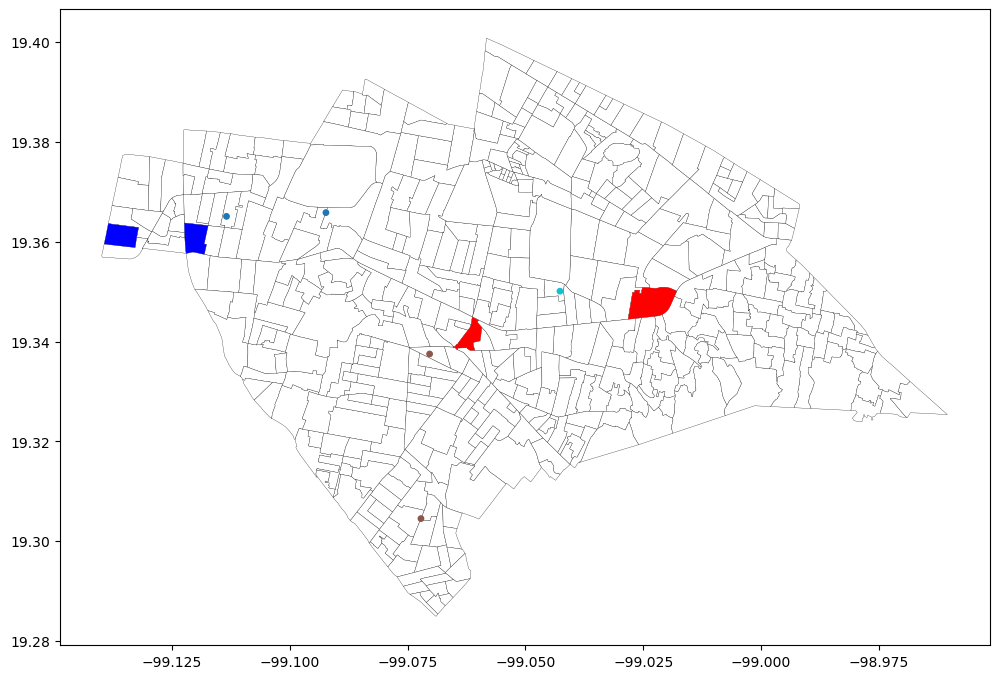

In [365]:
fig,ax=plt.subplots(figsize=(12,10))
iztapa.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
dftest5.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [366]:
grupo['pobreza'].unique()

array(['[ 0, 18]'], dtype=object)

In [367]:
dftest5['pobreza'].value_counts()

pobreza
(18, 34]    2
(34, 50]    2
(50, 70]    1
Name: count, dtype: int64

In [369]:
dftest5

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
197  ...         19-64             2     1.0  2020.0          5   
199  ...         19-64             2     1.0  2021.0          5   
200  ...         19-64             2     1.0  2020.0          5   
202  ...         19-64             2     1.0  2022.0          5   
204  ...         19-64             2     1.0  2021.0          5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
199  POINT (-99.07217 19.30454)   
200  POINT (-99.11344 19.36507)   
202  POINT (-99.04266 19.35008)   
204  POINT (-99.07033 19.33751)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   

      pobreza        IDS  
197  (18, 34]  8632653.0  
199  (34, 50]  8849170.0  
200  (18, 34]  8657148.0  
202  (50, 70]  9164291.0  
204  (34, 50]  9070654.0  

[5 rows x 39 columns]

In [368]:
central_point = find_central_point_by_community(dftest5, dist_matrix_df)
print("Punto central:", central_point)

# Acceder a las coordenadas o datos del punto central
if central_point:
    print("Datos del punto central:")
    print(gdf2.loc[central_point[0]])

Índices con el valor máximo: []
Punto central: None


In [370]:
root=dftest5[dftest5['IDS']==8657148.0]
root

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
200        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   

    FechaInicio                       Delito         Categoria       Sexo  \
200  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
200  ...         19-64             2     1.0  2020.0          5   

                       geometry  \
200  POINT (-99.11344 19.36507)   

                                                 color            CVE  \
200  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708   

      pobreza        IDS  
200  (18, 34]  8657148.0  

[1 rows x 39 columns]

<Axes: >

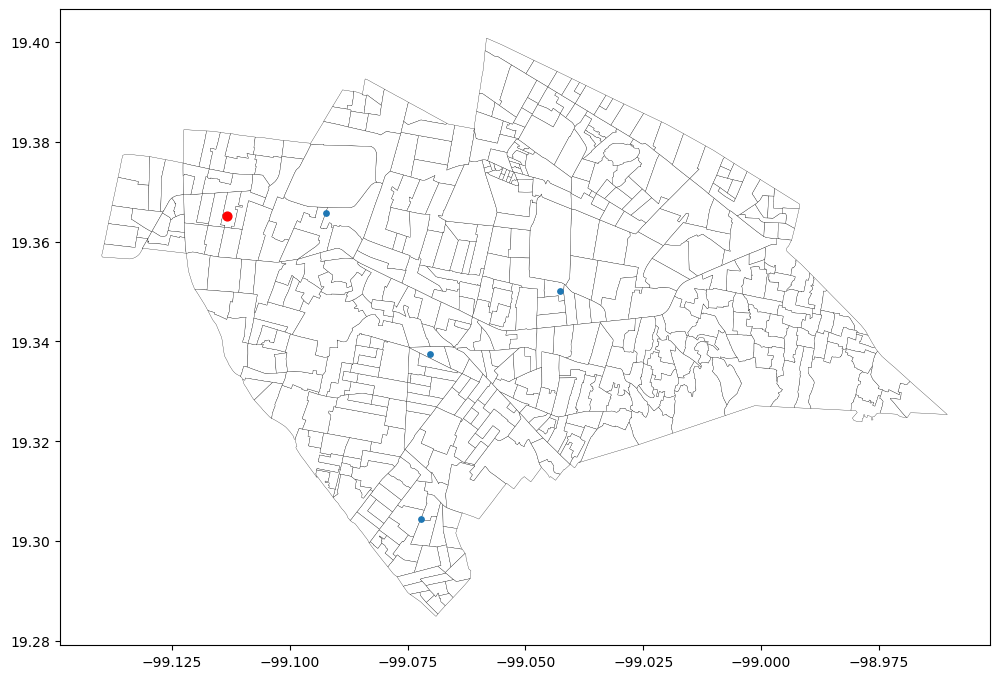

In [372]:
fig,ax=plt.subplots(figsize=(12,10))
iztapa.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest5.plot(ax=ax,markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [373]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'idCarpeta', 'Año_inicio',
       'Mes_inicio', 'FechaInicio', 'Delito', 'Categoria', 'Sexo', 'Edad',
       'TipoPersona', 'CalidadJuridica', 'competencia', 'Año_hecho',
       'Mes_hecho', 'FechaHecho', 'HoraHecho', 'HoraInicio', 'alcaldia_hechos',
       'municipio_hechos', 'colonia_datos', 'fgj_colonia_registro', 'latitud',
       'longitud', 'ageb', 'shp', 'longitudrad', 'latitudrad', 'grupo_etario',
       'grupo_etario2', 'genero2', 'año', 'comunidad', 'geometry', 'color',
       'CVE', 'pobreza', 'IDS'],
      dtype='object')

In [374]:
grupo['pobreza']

200    (18, 34]
Name: pobreza, dtype: object

In [375]:
dftest6=dftest5[dftest5['IDS'] != 8657148.0]
dftest6

Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
197        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   
199        2620.0  495088.0    499620.0  8849170.0      2021.0    Febrero   
202        3596.0  779615.0    786217.0  9164291.0      2022.0      Abril   
204        3370.0  693166.0    699214.0  9070654.0      2021.0  Noviembre   

    FechaInicio                       Delito         Categoria       Sexo  \
197  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
199  2021-02-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
202  2022-04-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
204  2021-11-29  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

     ...  grupo_etario grupo_etario2 genero2     año  comunidad  \
197  ...         19-64             2     1.0  2020.0          5   
199  ...         19-64             2     1.0  2021.0          5   
202  ...         19-64             2     1.0  2022.0          5   
204  ...         19-64             2     1.0  2021.0          5   

                       geometry  \
197  POINT (-99.09234 19.36582)   
199  POINT (-99.07217 19.30454)   
202  POINT (-99.04266 19.35008)   
204  POINT (-99.07033 19.33751)   

                                                 color            CVE  \
197  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750   
199  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012117   
202  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700011316   
204  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700012846   

      pobreza        IDS  
197  (18, 34]  8632653.0  
199  (34, 50]  8849170.0  
202  (50, 70]  9164291.0  
204  (34, 50]  9070654.0  

[4 rows x 39 columns]

In [376]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest6)):
    row2 = dftest6.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



   Unnamed: 0.1     index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0        1622.0  314886.0    318120.0  8657148.0      2020.0      Marzo   
1        1525.0  292082.0    295114.0  8632653.0      2020.0    Febrero   

  FechaInicio                       Delito         Categoria       Sexo  ...  \
0  2020-03-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   
1  2020-02-13  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino  ...   

   grupo_etario grupo_etario2 genero2     año  comunidad  \
0         19-64             2     1.0  2020.0          5   
1         19-64             2     1.0  2020.0          5   

                     geometry  \
0  POINT (-99.11344 19.36507)   
1  POINT (-99.09234 19.36582)   

                                               color            CVE   pobreza  \
0  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010708  (18, 34]   
1  (0.5490196078431373, 0.33725490196078434, 0.29...  0900700010750  (18, 34]   

        

In [377]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [378]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

2

In [379]:
dftest7 = dftest6[~dftest6['IDS'].isin(listaids)]
dftest7['pobreza'].unique()

array(['(34, 50]', '(50, 70]'], dtype=object)

In [166]:
len(grupo)

3

<Axes: >

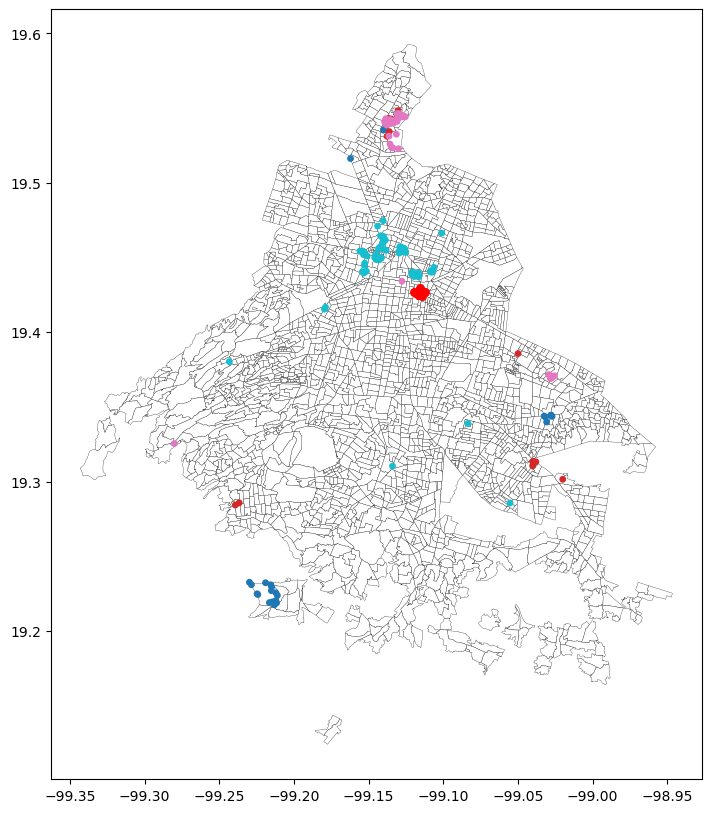

In [141]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest7.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [142]:
grupo['newgroup']=3

In [143]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo3 = gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo3 = pd.concat([alcgrupo3, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo3=gpd.GeoDataFrame(alcgrupo3,geometry=alcgrupo3.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_23336\3921591120.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


<Axes: >

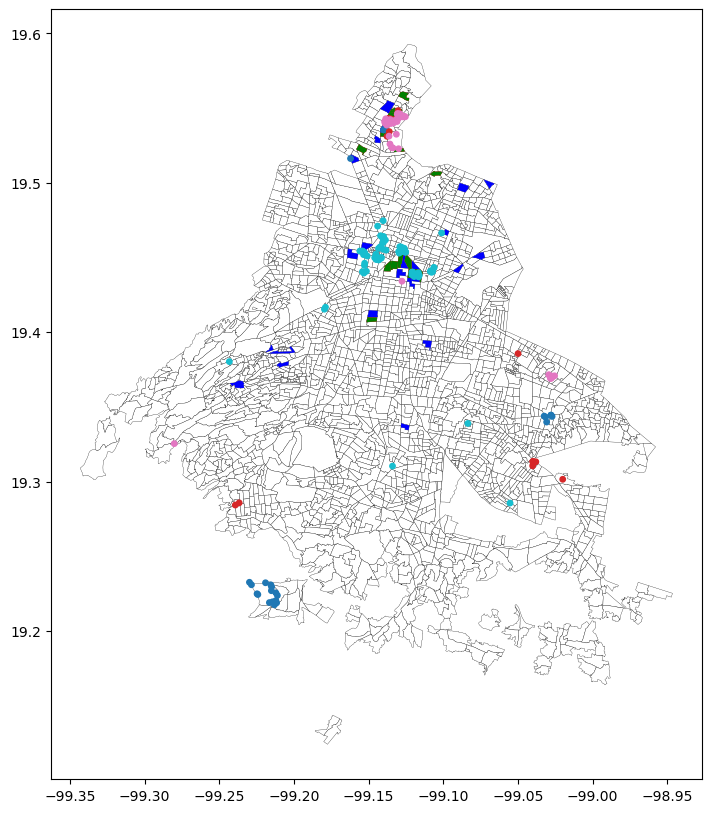

In [144]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
alcgrupo1.plot(ax=ax,color='green')
dftest7.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [145]:
grupo['pobreza'].unique()

array(['Sin viviendas particulares habitadas'], dtype=object)

In [146]:
dftest7['pobreza'].value_counts()

pobreza
[ 0, 18]    73
(50, 70]    44
(18, 34]    26
(34, 50]    15
Name: count, dtype: int64

In [147]:
central_point = find_central_point_by_community(dftest7, dist_matrix_df)
print("Punto central:", central_point)

# Acceder a las coordenadas o datos del punto central
if central_point:
    print("Datos del punto central:")
    print(gdf2.loc[central_point[0]])

Índices con el valor máximo: ['0901200262297']
Punto central: [393, '0901200262297']
Datos del punto central:
geometry    POINT (-99.2143529745062 19.2194783263529)
CVE                                      0901200262297
pobreza                                       (18, 34]
IDS                                                393
Name: 393, dtype: object


In [148]:
root=dftest7[dftest7['IDS']==central_point[0]]
root

geometry            CVE   pobreza  IDS
393  POINT (-99.21435 19.21948)  0901200262297  (18, 34]  393

<Axes: >

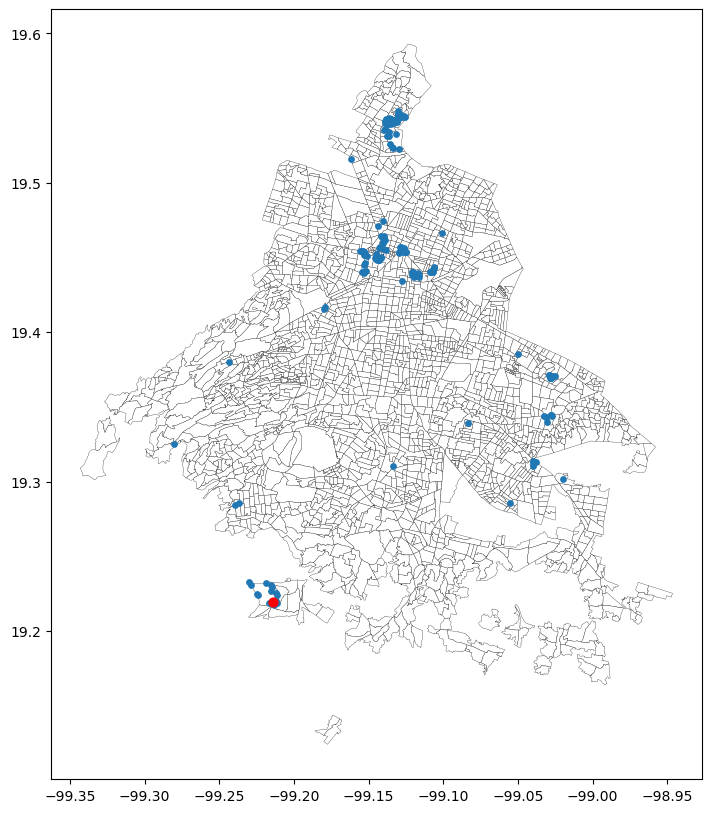

In [149]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest7.plot(ax=ax,markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [150]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['geometry', 'CVE', 'pobreza', 'IDS'], dtype='object')

In [151]:
grupo['pobreza']

393    (18, 34]
Name: pobreza, dtype: object

In [152]:
dftest8=dftest7[dftest7['IDS'] != central_point[0]]
dftest8

geometry            CVE   pobreza  IDS
1    POINT (-99.13660 19.54312)  0900500010169  (34, 50]    1
3    POINT (-99.13882 19.53587)  0900500010243  (18, 34]    3
4    POINT (-99.14006 19.53539)  0900500010243  (18, 34]    4
9    POINT (-99.03155 19.34312)  0900700014999  (18, 34]    9
10   POINT (-99.02009 19.30150)  0901100010753  (34, 50]   10
..                          ...            ...       ...  ...
537  POINT (-99.12771 19.43413)  0901500010771  (50, 70]  537
541  POINT (-99.13790 19.53864)  0900500010205  (50, 70]  541
545  POINT (-99.13991 19.46326)  0901500010080  [ 0, 18]  545
547  POINT (-99.12674 19.54411)  0900500013411  (50, 70]  547
550  POINT (-99.14508 19.44979)  0901500010517  [ 0, 18]  550

[157 rows x 4 columns]

In [153]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest8)):
    row2 = dftest8.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



                      geometry            CVE   pobreza  IDS
0   POINT (-99.21435 19.21948)  0901200262297  (18, 34]  393
1   POINT (-99.21907 19.23223)  0901200261674  (18, 34]   74
2   POINT (-99.22472 19.22486)  0901200262297  (18, 34]  127
3   POINT (-99.21300 19.21854)  0901200262297  (18, 34]  141
4   POINT (-99.22421 19.22435)  0901200262297  (18, 34]  173
5   POINT (-99.21550 19.23082)  0901200262297  (18, 34]  214
6   POINT (-99.21647 19.21896)  0901200262297  (18, 34]  296
7   POINT (-99.22849 19.23090)  0901200262297  (18, 34]  301
8   POINT (-99.22982 19.23256)  0901200262297  (18, 34]  347
9   POINT (-99.21217 19.22026)  0901200262297  (18, 34]  377
10  POINT (-99.21164 19.21880)  0901200262297  (18, 34]  385
11  POINT (-99.21311 19.21745)  0901200262297  (18, 34]  404
12  POINT (-99.21514 19.22692)  0901200262297  (18, 34]  444
13  POINT (-99.21211 19.22546)  0901200262297  (18, 34]  478
14  POINT (-99.21500 19.22944)  0901200262297  (18, 34]  500
15  POINT (-99.21111 19.

In [154]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [155]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

16

In [156]:
dftest9 = dftest8[~dftest8['IDS'].isin(listaids)]
dftest9['pobreza'].unique()

array(['(34, 50]', '(18, 34]', '(50, 70]', '[ 0, 18]'], dtype=object)

In [157]:
len(grupo)

16

<Axes: >

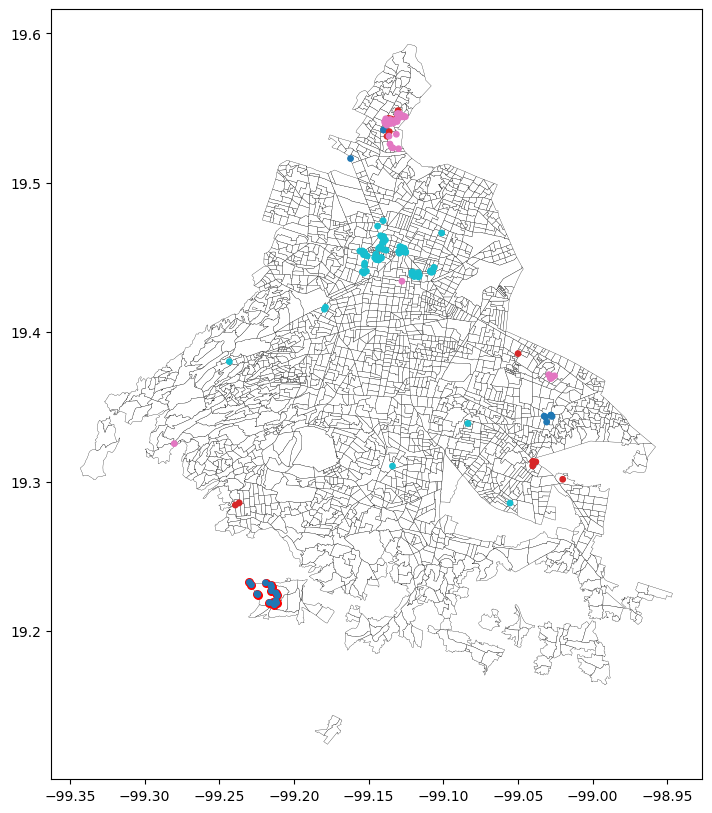

In [158]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest8.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [159]:
grupo['newgroup']=4

In [160]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo4 = gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo4 = pd.concat([alcgrupo4, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo4=gpd.GeoDataFrame(alcgrupo4,geometry=alcgrupo4.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_23336\984685965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


<Axes: >

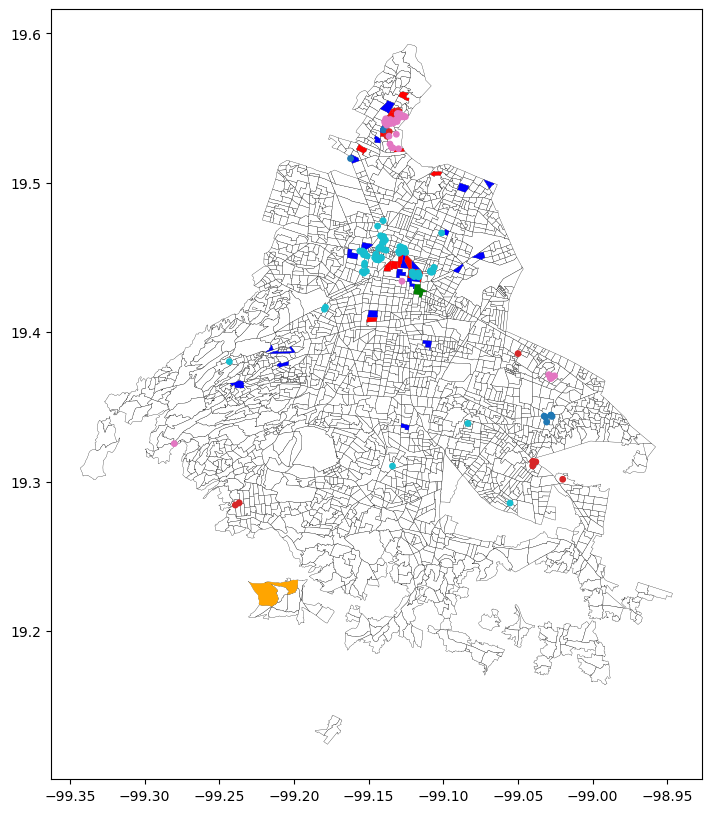

In [164]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
alcgrupo3.plot(ax=ax,color='green')
alcgrupo4.plot(ax=ax,color='orange')
dftest9.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [163]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)